In [1]:

import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import ttest_rel

In [2]:
from src import utils
from src.utils import print_title

In [3]:
import importlib
importlib.reload(utils)

<module 'src.utils' from '/Users/jobandtalent/Documents/GitHub/forecast-incremental-workflow/src/utils.py'>

## DATA INGESTION

### LOAD

In [4]:
day_df_raw = pd.read_csv('../data/day.csv')
display(day_df_raw.head())
print('DF Size: ', day_df_raw.shape)
print('DF Types: \n', day_df_raw.dtypes)

df = day_df_raw.copy()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


DF Size:  (731, 16)
DF Types: 
 instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


### DTYPES

In [5]:
datetime_columns = ['dteday']
float64_columns = ['temp','atemp','hum','windspeed']
str_columns = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
int64_columns = ['casual', 'registered', 'cnt']

# Basic data conversion
df = utils.format_columns(df, datetime_columns, int64_columns, float64_columns, str_columns)
# Rename columns
df.rename(columns={
    'dteday':'date',
    'yr':'year',
    'mnth':'month',
    'weathersit':'weather',
    'temp':'temperature',
    'atemp':'temperature_sensation',
    'hum':'humidity',
    'casual':'casual_users',
    'registered':'registered_users',
    'cnt':'bikes_rented'
}, inplace=True)
# Drop not used columns
df.drop(columns=['instant'], inplace=True)

# Check dtypes
print_title('CONVERTED DATA TYPES')
print(df.dtypes)
display(df.head(5))

------------------- CONVERTED DATA TYPES -------------------
date                     datetime64[ns]
season                           object
year                             object
month                            object
holiday                          object
weekday                          object
workingday                       object
weather                          object
temperature                     float64
temperature_sensation           float64
humidity                        float64
windspeed                       float64
casual_users                      Int64
registered_users                  Int64
bikes_rented                      Int64
dtype: object


,date,season,year,month,holiday,weekday,workingday,weather,temperature,temperature_sensation,humidity,windspeed,casual_users,registered_users,bikes_rented
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## DATA CLEANING AND QA

### DESCRIBE

In [6]:
# Quick checks on data
print_title('DF INFO')
display(df.info())

print_title('DF DESCRIBE')
display(df.describe())

# Check distribution of variants
print_title('DISTRIBUTIONS')
display(df['season'].value_counts().sort_index())
display(df['year'].value_counts().sort_index())
display(df['month'].value_counts().sort_index())
display(df['holiday'].value_counts().sort_index())
display(df['weekday'].value_counts().sort_index())
display(df['workingday'].value_counts().sort_index())
display(df['weather'].value_counts().sort_index())

------------------------- DF INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   731 non-null    datetime64[ns]
 1   season                 731 non-null    object        
 2   year                   731 non-null    object        
 3   month                  731 non-null    object        
 4   holiday                731 non-null    object        
 5   weekday                731 non-null    object        
 6   workingday             731 non-null    object        
 7   weather                731 non-null    object        
 8   temperature            731 non-null    float64       
 9   temperature_sensation  731 non-null    float64       
 10  humidity               731 non-null    float64       
 11  windspeed              731 non-null    float64       
 12  casu

None

----------------------- DF DESCRIBE -----------------------


,date,temperature,temperature_sensation,humidity,windspeed,casual_users,registered_users,bikes_rented
count,731,731.000000,731.000000,731.000000,731.000000,731.0,731.0,731.0
mean,2012-01-01 00:00:00,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
min,2011-01-01 00:00:00,0.059130,0.079070,0.000000,0.022392,2.0,20.0,22.0
25%,2011-07-02 12:00:00,0.337083,0.337842,0.520000,0.134950,315.5,2497.0,3152.0
50%,2012-01-01 00:00:00,0.498333,0.486733,0.626667,0.180975,713.0,3662.0,4548.0
75%,2012-07-01 12:00:00,0.655417,0.608602,0.730209,0.233214,1096.0,4776.5,5956.0
max,2012-12-31 00:00:00,0.861667,0.840896,0.972500,0.507463,3410.0,6946.0,8714.0
std,NaN,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452


---------------------- DISTRIBUTIONS ----------------------


season
1    181
2    184
3    188
4    178
Name: count, dtype: int64

year
0    365
1    366
Name: count, dtype: int64

month
1     62
10    62
11    60
12    62
2     57
3     62
4     60
5     62
6     60
7     62
8     62
9     60
Name: count, dtype: int64

holiday
0    710
1     21
Name: count, dtype: int64

weekday
0    105
1    105
2    104
3    104
4    104
5    104
6    105
Name: count, dtype: int64

workingday
0    231
1    500
Name: count, dtype: int64

weather
1    463
2    247
3     21
Name: count, dtype: int64

### DUPLICATES

In [7]:
# Check for and drop duplicates in the entire DataFrame
duplicated_rows = df.duplicated().sum()
print('# of duplicated rows: ', duplicated_rows)

if duplicated_rows > 0:
    df = df.drop_duplicates()
    print('Duplicates in the DataFrame removed.')
else:
    print('No duplicates in the DataFrame found.')

# of duplicated rows:  0
No duplicates in the DataFrame found.


In [8]:

primary_key_column = 'date'

# Check for duplicates in the unique columns
duplicated_rows = df[df[primary_key_column].duplicated(keep=False)]
print(f'# of duplicated on {primary_key_column} column: {duplicated_rows[primary_key_column].nunique()}')

if not duplicated_rows.empty:
    print(f'Duplicated {primary_key_column} and their rows:')
    display(duplicated_rows.sort_values(by = primary_key_column))

    # Keep only the first following timestamp column order
    if primary_key_column == '':
        df = df.drop_duplicates(subset=primary_key_column, keep='first')
        print('Kept the most recent row for each duplicated' +  primary_key_column)
    else:
        df = df.sort_values(primary_key_column).drop_duplicates(subset=primary_key_column, keep='first')
        print('Kept the most recent row for each duplicated ' + primary_key_column)

# of duplicated on date column: 0


### NULLS

In [9]:
# Check for missing values
missing_values = df.isnull().sum()
print_title('NUMBER OF NULL VALUES')
print(missing_values)

------------------ NUMBER OF NULL VALUES ------------------
date                     0
season                   0
year                     0
month                    0
holiday                  0
weekday                  0
workingday               0
weather                  0
temperature              0
temperature_sensation    0
humidity                 0
windspeed                0
casual_users             0
registered_users         0
bikes_rented             0
dtype: int64


### OUTLIERS

In [10]:
target_columns = ['casual_users', 'registered_users', 'bikes_rented']

numeric_cols = df.drop(columns=target_columns, errors='ignore').select_dtypes(include=["number"])
outliers_df = utils.detect_outliers(numeric_cols, method="iqr")
outlier_rows = df.loc[outliers_df.any(axis=1)]
print_title('ANOMALY ROWS')
display(outliers_df[outliers_df['is_outlier']])

df["extreme_weather"] = outliers_df["is_outlier"].astype(int).astype(str)
display(df.head())

----------------------- ANOMALY ROWS -----------------------


,iqr_outlier,zscore_outlier,outlier_columns,is_outlier
44,True,False,[windspeed],True
49,True,False,"[humidity, windspeed]",True
68,True,False,[humidity],True
93,True,False,[windspeed],True
94,True,False,[windspeed],True
292,True,False,[windspeed],True
382,True,False,[windspeed],True
407,True,False,[windspeed],True
420,True,False,[windspeed],True
432,True,False,[windspeed],True


,date,season,year,month,holiday,weekday,workingday,weather,temperature,temperature_sensation,humidity,windspeed,casual_users,registered_users,bikes_rented,extreme_weather
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,0
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,0
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,0
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,0
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,0


## EDA

In [11]:
target_column = 'bikes_rented'
try:
    df.drop(columns=['registered_users', 'casual_users'], inplace= True)
except:
    pass
display(df.head())

,date,season,year,month,holiday,weekday,workingday,weather,temperature,temperature_sensation,humidity,windspeed,bikes_rented,extreme_weather
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,0
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,0
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,0
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,0


In [12]:
def plot_time_series(df, time_series, p_alpha = 0.9, p_linestyle = "--"):
    fig, ax = plt.subplots(figsize=(20,6))
    
    colors = plt.get_cmap("tab10")(range(len(time_series)))
    for i, serie in enumerate(time_series):
        alpha = p_alpha if i > 0 else 1
        linestyle = p_linestyle if i > 0 else "-"
        
        ax.plot(df['date'], df[serie], label=serie, linewidth=2, color=colors[i], alpha=alpha, linestyle=linestyle)

    ax.set_title("Bikes rented", fontsize=14, fontweight='bold')

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.tick_params(axis='y', labelsize=10)

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(frameon=False, fontsize=12)

    plt.show()

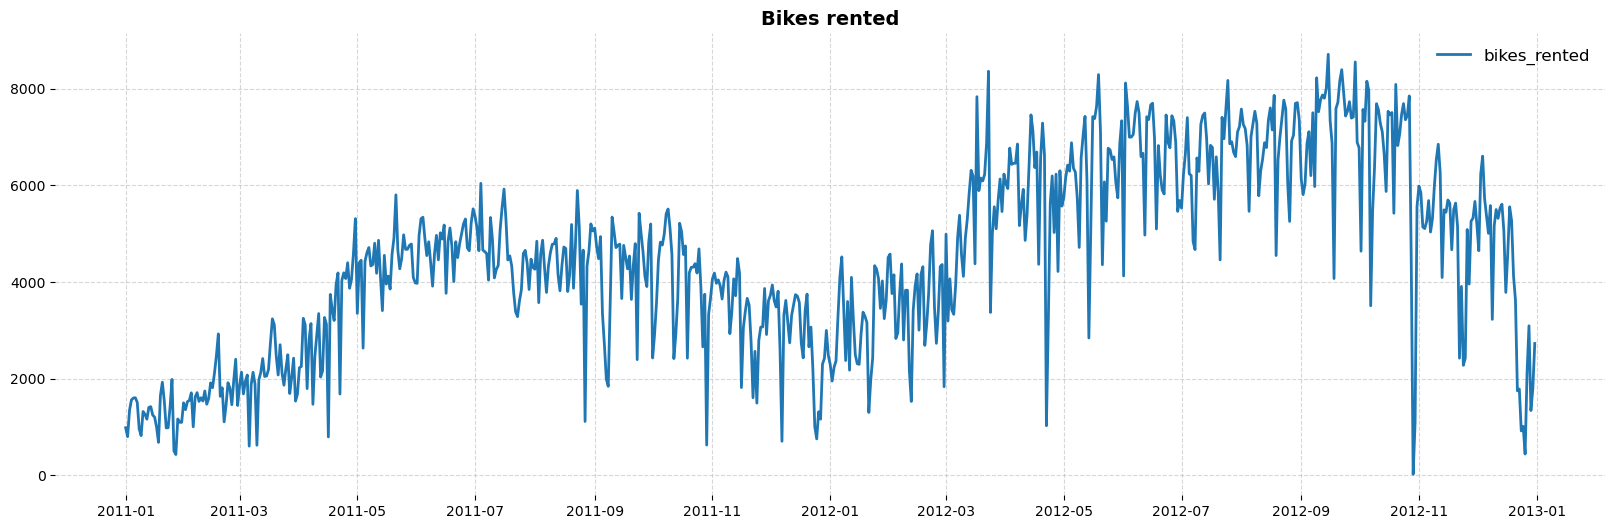

In [13]:
plot_time_series(df, [target_column], 0.9, '--')

### STATIONARITY

In [14]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["bikes_rented"])
print(f"ADF Statistic: {result[0]}")
print(f"P-value: {result[1]}")
print("Conclusion:", "Stationary" if result[1] < 0.05 else "Non-stationary")

ADF Statistic: -1.8774481444374296
P-value: 0.34274344033921944
Conclusion: Non-stationary


### TREND

In [67]:
from statsmodels.tsa.stattools import kpss

result = kpss(df["bikes_rented"], regression="c")
print(f"KPSS Statistic: {result[0]}")
print(f"P-value: {result[1]}")
print("Conclusion:", "Trend present" if result[1] < 0.05 else "No significant trend")

KPSS Statistic: 2.424033427910016
P-value: 0.01
Conclusion: Trend present


/var/folders/hv/ckh3m6gn1sd45q2qctrqcwzh0000gn/T/ipykernel_12888/288241163.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df["bikes_rented"], regression="c")


### TIME PERSISTENCE AND SEASONALITY

In [16]:
import numpy as np
from statsmodels.tsa.stattools import acf

nlags = 365
acf_values = acf(df["bikes_rented"], nlags=nlags, fft=True)

autocorrelated_lags = np.where(np.abs(acf_values) > 0.5)[0]
autocorrelation_ratio = len(autocorrelated_lags) / nlags

seasonal_lags = [lag for lag in autocorrelated_lags if lag % 7 == 0 or lag % 30 == 0 or lag % 365 == 0]

print(f"Lags with autocorrelation: {autocorrelated_lags.tolist()}")
print(f"Percentage of significant lags: {autocorrelation_ratio:.2%}")
print(f"Possible seasonal lags: {seasonal_lags}")

if autocorrelation_ratio > 0.5:
    print("Strong temporal dependence detected.")
elif autocorrelation_ratio > 0.3:
    print("Moderate temporal dependence detected.")
else:
    print("Low temporal dependence.")

if len(seasonal_lags) > 2:
    print("Seasonality detected.")
else:
    print("No clear seasonality.")

Lags with autocorrelation: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51]
Percentage of significant lags: 13.97%
Possible seasonal lags: [0, 7, 14, 21, 28, 30, 35, 42, 49]
Low temporal dependence.
Seasonality detected.


### ACF AND PACF

In [17]:
def plot_acf_and_pacf(input_df, additional_text = ''):
    fig, axes = plt.subplots(1, 2, figsize=(16, 3))

    plot_acf(input_df, ax=axes[0], lags=50)
    plot_pacf(input_df, ax=axes[1], lags=50)

    axes[0].set_title("ACF" + additional_text, fontsize=14, fontweight='bold')
    axes[1].set_title("PACF" + additional_text, fontsize=14, fontweight='bold')

    for ax in axes:
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()

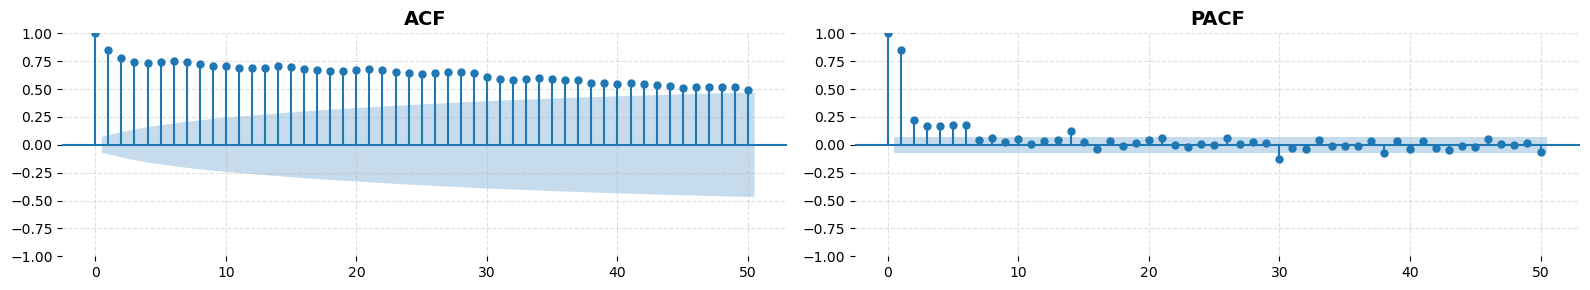

In [18]:
plot_acf_and_pacf(df[target_column])

### DECOMPOSITION

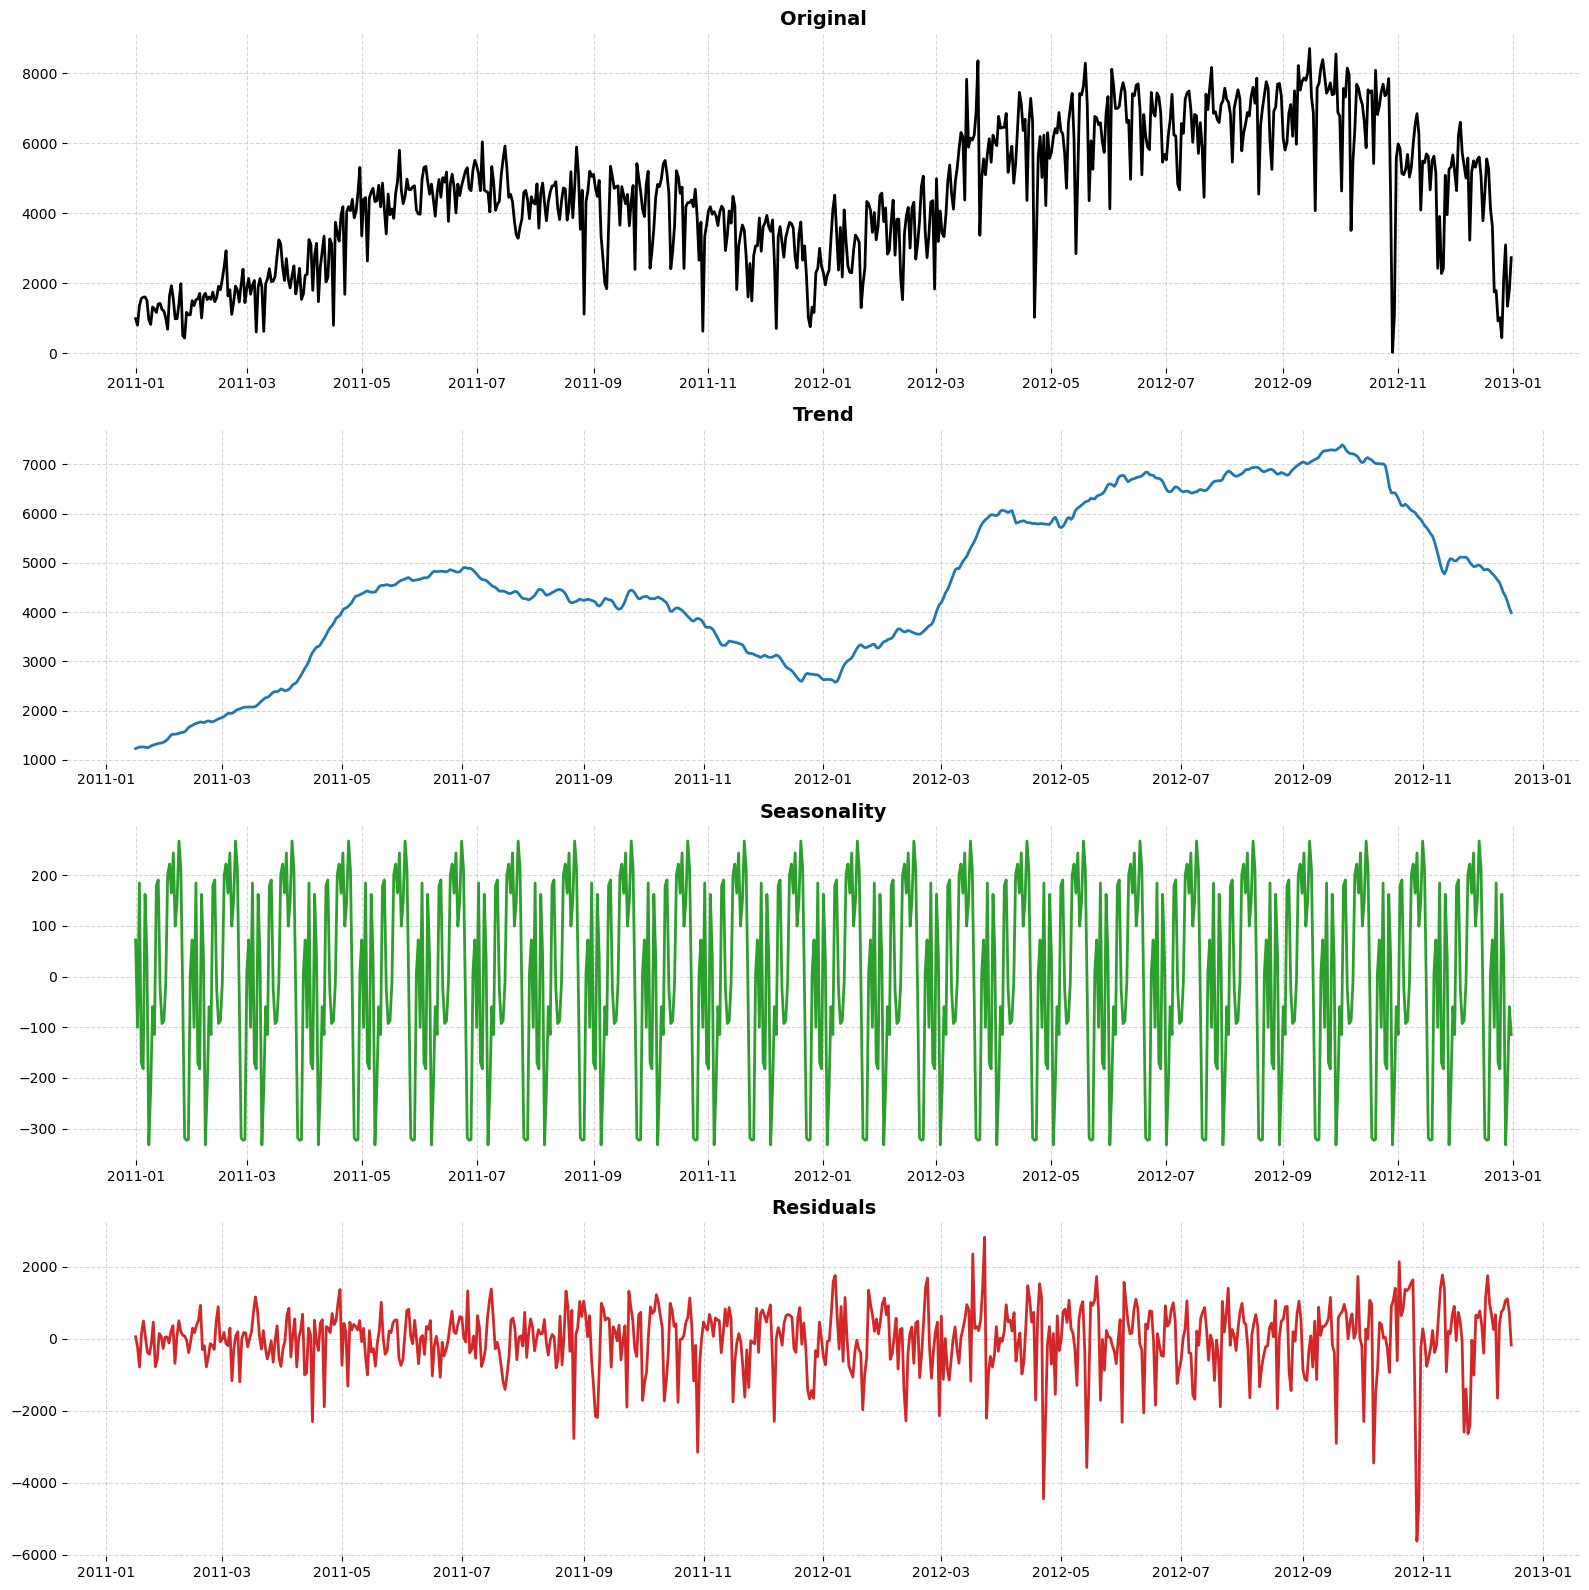

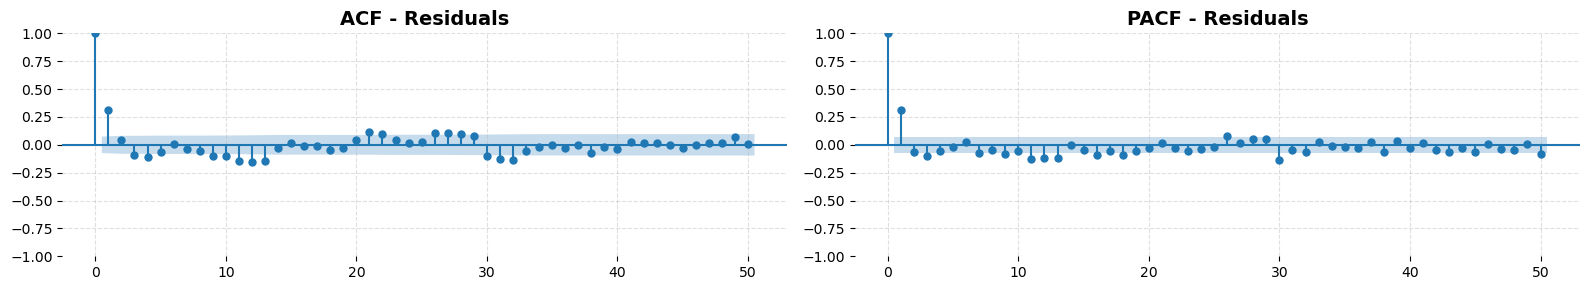

In [19]:
decomposed = seasonal_decompose(df[target_column], model='additive', period=30)

fig, axes = plt.subplots(4, 1, figsize=(16, 16))

axes[0].plot(df["date"], decomposed.observed, color="black", linewidth=2)
axes[0].set_title("Original", fontsize=14, fontweight='bold')

axes[1].plot(df["date"], decomposed.trend, color="tab:blue", linewidth=2)
axes[1].set_title("Trend", fontsize=14, fontweight='bold')

axes[2].plot(df["date"], decomposed.seasonal, color="tab:green", linewidth=2)
axes[2].set_title("Seasonality", fontsize=14, fontweight='bold')

axes[3].plot(df["date"], decomposed.resid, color="tab:red", linewidth=2)
axes[3].set_title("Residuals", fontsize=14, fontweight='bold')

for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.tick_params(axis='x', rotation=0, labelsize=10)

plt.tight_layout()
plt.show()

plot_acf_and_pacf(decomposed.resid.dropna(), ' - Residuals')

### OUTLIERS

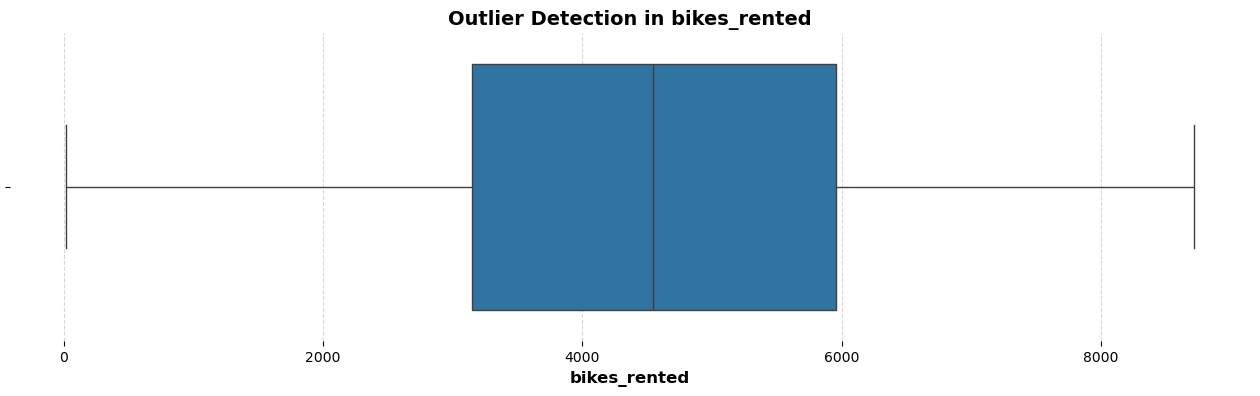

In [20]:
fig, ax = plt.subplots(figsize=(16,4))

sns.boxplot(
    x=df[target_column], 
    ax=ax, 
    flierprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black", "markersize": 6}
)

ax.set_title(f"Outlier Detection in {target_column}", fontsize=14, fontweight="bold")
ax.set_xlabel(target_column, fontsize=12, fontweight="bold")

for spine in ax.spines.values():
    spine.set_visible(False)

ax.grid(axis="x", linestyle="--", alpha=0.5)

plt.show()

### EXOGENS

In [21]:
excluded_columns = ["bikes_rented", "date"]

exogen_columns = [
    col for col in df.columns 
    if col not in excluded_columns and df[col].dtype in ["int64", "float64", "uint8", "object"]
]
print("Exogenous variables for forecasting:", exogen_columns)

Exogenous variables for forecasting: ['season', 'year', 'month', 'holiday', 'weekday', 'workingday', 'weather', 'temperature', 'temperature_sensation', 'humidity', 'windspeed', 'extreme_weather']


### NUMERIC CORRELATION AND COLLINEARITY

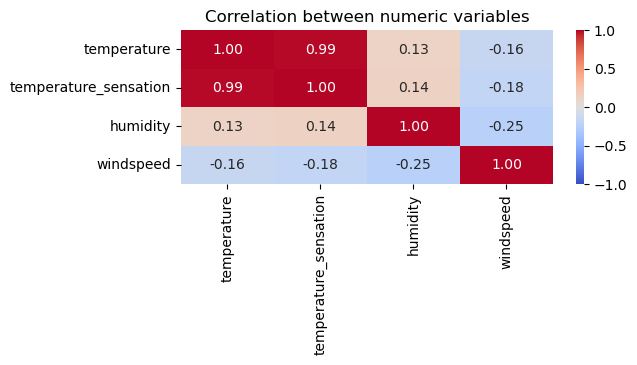

In [22]:
plt.figure(figsize=(6, 2))
df_numeric_to_corr = df.select_dtypes(include=["number"]).drop(columns=[target_column], errors="ignore")
df_corr = df_numeric_to_corr.corr()
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between numeric variables")
plt.show()

In [23]:
X = df_numeric_to_corr.dropna().select_dtypes(include=["number"]).astype("float64")

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

corr_matrix = X.corr().abs()
high_corr_pairs = np.where(corr_matrix > 0.8)
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j]) 
                   for i, j in zip(*high_corr_pairs) if i != j and i < j]

print("Highly correlated variable pairs:", high_corr_pairs)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)

print('\n')
print("VIF:")
print(vif_data)

target_corr = df.corr()["bikes_rented"].drop(["bikes_rented", "date"])
print('\n')
print("ABS Correlation values:")
print(abs(target_corr).sort_values(ascending=False))

Highly correlated variable pairs: [('temperature', 'temperature_sensation')]


VIF:
                Variable         VIF
1  temperature_sensation  543.242186
0            temperature  488.553062
2               humidity   11.064126
3              windspeed    4.682492


ABS Correlation values:
temperature_sensation    0.631066
temperature              0.627494
year                     0.566710
season                   0.406100
weather                  0.297391
month                    0.279977
windspeed                0.234545
extreme_weather          0.105338
humidity                 0.100659
holiday                  0.068348
weekday                  0.067443
workingday               0.061156
Name: bikes_rented, dtype: float64


## BASE FORECAST FEATURE ENGINEERING

### FEATURE SELECTION

In [24]:
features_to_remove = set()
for pair in high_corr_pairs:
    feature_to_remove = pair[0] if abs(target_corr[pair[0]]) < abs(target_corr[pair[1]]) else pair[1]
    features_to_remove.add(feature_to_remove)

# Remove high VIF features (threshold >10)
high_vif_features = vif_data[vif_data["VIF"] > 10]["Variable"].tolist()
features_to_remove.update(high_vif_features)

# Select relevant features
selected_features = [feature for feature in exogen_columns if feature not in features_to_remove]
selected_features = sorted(selected_features, key=lambda x: abs(target_corr[x]), reverse=True)
print("Final selected exogenous variables:", selected_features)

Final selected exogenous variables: ['year', 'season', 'weather', 'month', 'windspeed', 'extreme_weather', 'holiday', 'weekday', 'workingday']


### TIME NORMALIZATION

In [25]:
use_time_normalization = False
df_selection = df.copy()
target_time_norm_column = target_column + "_time_norm"

if use_time_normalization:
    forecast_column = target_time_norm_column
    df_selection[forecast_column] = df[target_column] / df["date"].dt.days_in_month
    try:
        df_selection.drop(columns=target_column, inplace=True)
    except:
        pass
else:
    forecast_column = target_column
    try:
        df_selection.drop(columns=target_time_norm_column, inplace=True)
    except:
        pass

print('Forecast variable: ', forecast_column)
display(df_selection.head(1))

Forecast variable:  bikes_rented


,date,season,year,month,holiday,weekday,workingday,weather,temperature,temperature_sensation,humidity,windspeed,bikes_rented,extreme_weather
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,0


### TRANSFORMATIONS

In [26]:
def check_transformations(df_selection):
    numeric_vars = df_selection.select_dtypes(include=["number"]).columns
    transformations_needed = {}

    for col in numeric_vars:
        result = {}

        p_value = adfuller(df_selection[col].dropna())[1]
        result["stationary"] = p_value < 0.05  # True = Stationary, False = Not Stationary
        
        if not result["stationary"]:  # If not stationary
            if df_selection[col].min() > 0:  # Check if all values are positive
                boxcox_lambda = boxcox(df_selection[col] + 1)[1]  # +1 to avoid log(0) errors
                if abs(boxcox_lambda - 1) > 0.1:
                    result["recommended_transformation"] = "boxcox"
                else:
                    result["recommended_transformation"] = "log"
            else:
                result["recommended_transformation"] = "diff"
        else:
            result["recommended_transformation"] = "none"
        
        transformations_needed[col] = result

    transformations_df = pd.DataFrame(transformations_needed).T
    print(transformations_df)
    return transformations_df
        

def apply_transformations(df_selection, transformations):
    df_transformed = df_selection.copy()
    for col, row in transformations.iterrows():
        transformation = row["recommended_transformation"]
        
        if transformation == "diff":
            df_transformed[col] = df_selection[col].diff().dropna()
        elif transformation == "log":
            df_transformed[col] = np.log1p(df_selection[col])  # log1p avoids log(0) issues
        elif transformation == "boxcox":
            df_transformed[col], _ = boxcox(df_selection[col] + 1)  # +1 to handle zero values

    print("Transformations applied successfully.")
    display(df_transformed.head())
    return df_transformed

In [27]:
df_selection = df_selection[['date'] + selected_features + [forecast_column]]

print_title('Recommended Transformations')
transformations = utils.check_transformations(df_selection)

print('\n')
print_title('DF Prepared')
df_transformed = utils.apply_transformations(df_selection, transformations)
print('Forecast variable: ', forecast_column)

--------------- Recommended Transformations ---------------
             stationary recommended_transformation
windspeed          True                       none
bikes_rented      False                     boxcox


----------------------- DF Prepared -----------------------
Transformations applied successfully.


,date,year,season,weather,month,windspeed,extreme_weather,holiday,weekday,workingday,bikes_rented
0,2011-01-01,0,1,2,1,0.160446,0,0,6,0,499.329506
1,2011-01-02,0,1,2,1,0.248539,0,0,0,0,415.834439
2,2011-01-03,0,1,1,1,0.248309,0,0,1,1,659.495676
3,2011-01-04,0,1,1,1,0.160296,0,0,2,1,750.805907
4,2011-01-05,0,1,1,1,0.186900,0,0,3,1,766.938328


Forecast variable:  bikes_rented


## BASELINE AND VALIDATION

### BASELINE

In [28]:
def naive_forecast(df, forecast_column, date_column="date", steps=30):
    df_forecast = df.copy()
    
    df_forecast[date_column] = pd.to_datetime(df_forecast[date_column])
    
    df_forecast["naive_forecast"] = df_forecast[forecast_column].shift(1)
    df_forecast["is_future_forecast"] = False  # Mark historical data

    time_deltas = df_forecast[date_column].diff().dropna()
    most_common_delta = time_deltas.mode()[0] if not time_deltas.empty else pd.Timedelta(days=1)

    last_date = df_forecast[date_column].iloc[-1]
    future_dates = [last_date + most_common_delta * i for i in range(1, steps + 1)]

    future_forecast = pd.DataFrame(index=range(steps), columns=df.columns)
    future_forecast[date_column] = future_dates  # Assign new future dates
    future_forecast[forecast_column] = None  # No real values for the future
    future_forecast["naive_forecast"] = df_forecast[forecast_column].iloc[-1]  # Naïve prediction
    future_forecast["is_future_forecast"] = True  # Mark as future data

    df_final = pd.concat([df_forecast, future_forecast], ignore_index=True)

    return df_final

In [29]:
df_naive_forecast = naive_forecast(df_transformed, forecast_column, steps=60)
baseline_forecast_column = 'naive_forecast'

### VALIDATION

In [30]:
def plot_time_series_forecast(df, time_series, p_alpha=0.9, p_linestyle="--", plot_ci = True, use_ci_scale_factor = None):
    fig, ax = plt.subplots(figsize=(20,6))
    
    colors = plt.get_cmap("tab10")(range(len(time_series)))
    future_mask = df["is_future_forecast"] == True

    if len(time_series) > 1:
        first_future_date = df.loc[future_mask, "date"].min()
    else:
        first_future_date = None
        
    for i, serie in enumerate(time_series):
        alpha = p_alpha if i > 0 else 1
        linestyle = p_linestyle if i > 0 else "-"

        ax.plot(df["date"], df[serie], label=serie, linewidth=2, color=colors[i], alpha=alpha, linestyle=linestyle)

        if i > 0 and plot_ci:
            mean_forecast = df.loc[future_mask, serie]

            past_errors = df.loc[~future_mask, forecast_column] - df.loc[~future_mask, serie]
            std_dev = past_errors.std()  
            
            forecast_horizon = np.arange(1, len(mean_forecast) + 1) 
            
            if use_ci_scale_factor == 'log':
                scale_factor = np.log1p(forecast_horizon)
            elif use_ci_scale_factor == 'sqrt':
                scale_factor = np.sqrt(forecast_horizon)
            else:
                scale_factor = 1

            lower_80 = mean_forecast - 1.28 * std_dev * scale_factor
            upper_80 = mean_forecast + 1.28 * std_dev * scale_factor
            lower_95 = mean_forecast - 1.96 * std_dev * scale_factor
            upper_95 = mean_forecast + 1.96 * std_dev * scale_factor
            
            ax.fill_between(df.loc[future_mask, "date"], lower_95, upper_95, color=colors[i], alpha=0.2, label=f"{serie} 95% CI")
            ax.fill_between(df.loc[future_mask, "date"], lower_80, upper_80, color=colors[i], alpha=0.4, label=f"{serie} 80% CI")


    if first_future_date:
        ax.axvline(first_future_date, color="black", linestyle="-", linewidth=2, alpha = 0.3,  label="Forecast Start")

    ax.set_title("Bikes Rented Forecast", fontsize=14, fontweight="bold")

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.tick_params(axis="y", labelsize=10)

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(frameon=False, fontsize=12)

    plt.show()

#### METRICS

In [52]:
def mase(y_true, y_pred, y_naive):
    naive_mae = mean_absolute_error(y_true, y_naive)
    model_mae = mean_absolute_error(y_true, y_pred)
    return model_mae / naive_mae if naive_mae != 0 else np.nan

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

def calculate_forecast_metrics(df_naive, df_forecast, to_forecast_column, forecasted_column):
    try:
        df_forecast_clean = df_forecast.drop(columns = 'naive_forecast')
    except:
        df_forecast_clean = df_forecast.copy()
    df_merged = df_forecast_clean.merge(df_naive[["date", 'naive_forecast']], on="date", how="left")
    valid_mask = df_merged[to_forecast_column].notna() & df_merged[forecasted_column].notna() & (df_merged["is_future_forecast"] == False)

    if valid_mask.sum() == 0:
        return {metric: np.nan for metric in ["MAE", "RMSE", "SMAPE", "MASE"]}

    y_true = df_merged.loc[valid_mask, to_forecast_column]
    y_pred = df_merged.loc[valid_mask, forecasted_column]
    y_naive = df_merged.loc[valid_mask, 'naive_forecast']

    metrics = {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "SMAPE": smape(y_true, y_pred),
        "MASE": mase(y_true, y_pred, y_naive),
    }

    return metrics


In [32]:
model_metrics = calculate_forecast_metrics(df_naive_forecast, df_naive_forecast, forecast_column, "naive_forecast")
print(model_metrics)

{'MAE': 278.5863254953301, 'RMSE': 407.23722669057526, 'SMAPE': 18.142430243257664, 'MASE': 1.0}


#### TIME VALIDATION

In [33]:
def walk_forward_validation(df_naive, df_forecast, to_forecast_column, forecasted_column, steps=30, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []

    df_historical = df_forecast[df_forecast["is_future_forecast"] == False]

    for train_index, test_index in tscv.split(df_historical):
        train, test = df_historical.iloc[train_index], df_historical.iloc[test_index]

        metrics = calculate_forecast_metrics(df_naive, test, to_forecast_column, forecasted_column)
        results.append(metrics)

    return results

def expanding_window_validation(df_naive, df_forecast, to_forecast_column, forecasted_column, steps=30, initial_train_size=100):
    results = []
    df_historical = df_forecast[df_forecast["is_future_forecast"] == False]
    train_size = initial_train_size

    while train_size < len(df_historical) - steps:
        train, test = df_historical.iloc[:train_size], df_historical.iloc[train_size:train_size + steps]

        metrics = calculate_forecast_metrics(df_naive, test, to_forecast_column, forecasted_column)
        results.append(metrics)
        train_size += steps  # Expand window

    return results

def rolling_window_validation(df_naive, df_forecast, to_forecast_column, forecasted_column, steps=30, window_size=100):
    results = []
    df_historical = df_forecast[df_forecast["is_future_forecast"] == False]
    start = 0

    while start + window_size + steps < len(df_historical):
        train, test = df_historical.iloc[start:start + window_size], df_historical.iloc[start + window_size:start + window_size + steps]

        metrics = calculate_forecast_metrics(df_naive, test, to_forecast_column, forecasted_column)
        results.append(metrics)
        start += steps  # Move the window

    return results


In [34]:
# Walk-Forward Validation
walk_results = walk_forward_validation(df_naive_forecast, df_naive_forecast, "bikes_rented", "naive_forecast", steps=30, n_splits=5)

# Expanding Window Validation
expanding_results = expanding_window_validation(df_naive_forecast, df_naive_forecast, "bikes_rented", "naive_forecast", steps=30, initial_train_size=100)

# Rolling Window Validation
rolling_results = rolling_window_validation(df_naive_forecast, df_naive_forecast, "bikes_rented", "naive_forecast", steps=30, window_size=100)

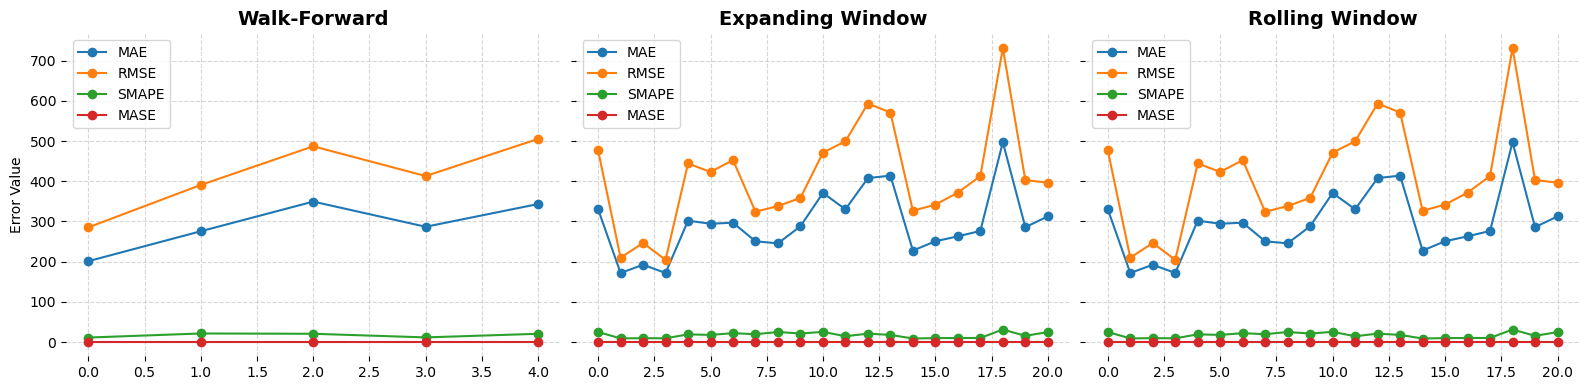

In [ ]:
def plot_validation_results(walk_results, expanding_results, rolling_results):
    metrics = ["MAE", "RMSE", "SMAPE", "MASE"]
    results = {
        "Walk-Forward": walk_results,
        "Expanding Window": expanding_results,
        "Rolling Window": rolling_results,
    }
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

    for i, (name, result) in enumerate(results.items()):
        df_results = pd.DataFrame(result)
        
        for metric in metrics:
            axes[i].plot(df_results.index, df_results[metric], marker="o", label=metric)
        
        axes[i].set_title(name, fontsize=14, fontweight="bold")
        axes[i].grid(True, linestyle="--", alpha=0.5)
        axes[i].legend(loc="upper left")
    for ax in axes:
        for spine in ax.spines.values():
            spine.set_visible(False)        
    axes[0].set_ylabel("Error Value")
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_validation_results(walk_results, expanding_results, rolling_results)

#### RESIDUALS

In [ ]:
def check_forecast_residuals(df_forecast, to_forecast_column, forecasted_column):
    df_residuals = df_forecast.copy()

    df_residuals["residuals"] = df_residuals[to_forecast_column] - df_residuals[forecasted_column]

    mean_residuals = df_residuals["residuals"].mean()
    std_residuals = df_residuals["residuals"].std()
    
    upper_bound = mean_residuals + 1.96 * std_residuals
    lower_bound = mean_residuals - 1.96 * std_residuals

    fig, ax = plt.subplots(figsize=(16, 3))
    ax.plot(df_residuals["date"], df_residuals["residuals"], label="Residuals", color="tab:blue", linewidth=1)
    ax.axhline(0, color="black", linestyle="--", alpha=0.6, label="Zero Line")
    
    ax.axhline(upper_bound, color="red", linestyle="--", alpha=0.7, label="95% CI")
    ax.axhline(lower_bound, color="red", linestyle="--", alpha=0.7)

    ax.set_title("Residuals of Forecast", fontsize=14, fontweight="bold")
    ax.grid(True, linestyle="--", alpha=0.4)

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()

    plot_acf_and_pacf(df_residuals["residuals"].dropna(), additional_text=" - Residuals")

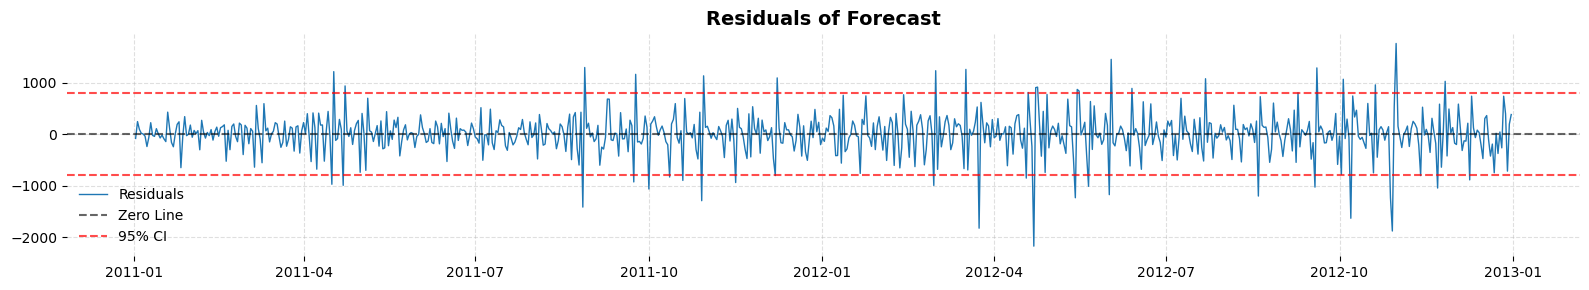

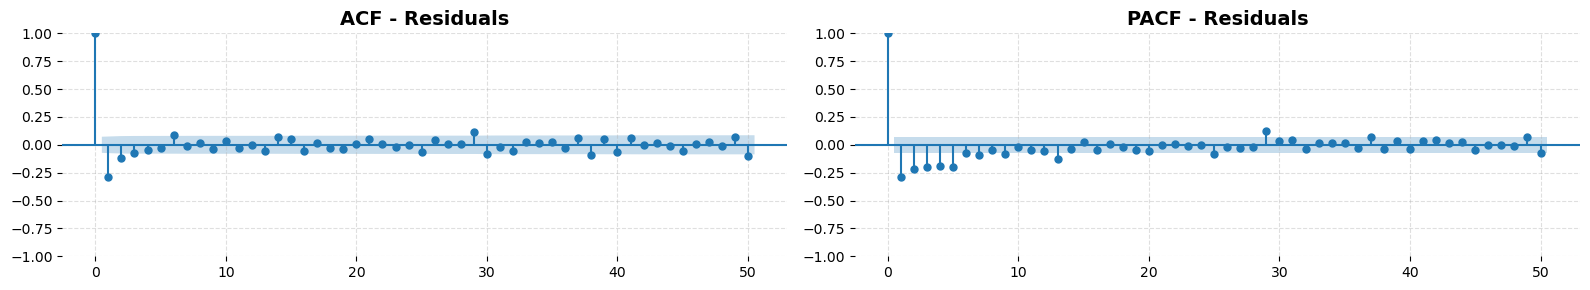

In [ ]:
check_forecast_residuals(df_naive_forecast, "bikes_rented", "naive_forecast")


#### BASELINE COMPARISON

In [37]:
def diebold_mariano_test(y_true, y_model, y_baseline):
    errors_model = np.abs(y_true - y_model)
    errors_baseline = np.abs(y_true - y_baseline)
    
    _, p_value = ttest_rel(errors_model, errors_baseline)
    
    return p_value

def compare_forecast_models(df_naive, df_baseline, df_forecast, to_forecast_column, forecasted_column, baseline_column="naive_forecast"):
    model_metrics = calculate_forecast_metrics(df_naive, df_forecast, to_forecast_column, forecasted_column)
    baseline_metrics = calculate_forecast_metrics(df_naive, df_baseline, to_forecast_column, baseline_column)

    df_merged = df_forecast.drop(columns=baseline_column, errors="ignore").merge(
        df_baseline[["date", baseline_column]], on="date", how="left"
    )

    valid_mask = df_merged[to_forecast_column].notna() & df_merged[forecasted_column].notna() & (df_merged["is_future_forecast"] == False)

    if valid_mask.sum() == 0:
        return {metric: np.nan for metric in ["MAE", "RMSE", "SMAPE", "MASE"]}

    y_true = df_merged.loc[valid_mask, to_forecast_column]
    y_pred = df_merged.loc[valid_mask, forecasted_column]
    y_naive = df_merged.loc[valid_mask, baseline_column]

    dm_p_value = diebold_mariano_test(y_true, y_pred, y_naive)

    comparison = {
        metric: {
            "Model": model_metrics[metric],
            "Baseline": baseline_metrics[metric],
            "Improvement": (baseline_metrics[metric] - model_metrics[metric]) / baseline_metrics[metric] * 100 if baseline_metrics[metric] != 0 else np.nan
        }
        for metric in model_metrics
    }

    comparison["DM Test p-value"] = dm_p_value
    comparison["Statistical Significance"] = "Significant" if dm_p_value < 0.05 else "Not Significant"

    return comparison

def format_comparison_results(comparison_results):
    metrics = {k: v for k, v in comparison_results.items() if isinstance(v, dict)}
    
    df_metrics = pd.DataFrame(metrics).T
    df_metrics.loc["DM Test p-value", :] = ["", "", str(comparison_results.get("DM Test p-value", "NaN"))]
    df_metrics.loc["Statistical Significance", :] = ["", "", str(comparison_results.get("Statistical Significance", "Unknown"))]

    return df_metrics

In [38]:
comparison_results = compare_forecast_models(df_naive_forecast, df_naive_forecast, df_naive_forecast, forecast_column, "naive_forecast")
df_formatted = format_comparison_results(comparison_results)
display(df_formatted)

,Model,Baseline,Improvement
MAE,278.586325,278.586325,0.0
RMSE,407.237227,407.237227,0.0
SMAPE,18.14243,18.14243,0.0
MASE,1.0,1.0,0.0
DM Test p-value,,,nan
Statistical Significance,,,Not Significant


#### COMPLETE VALIDATION FRAMEWORK

In [ ]:
def validate_forecast(df_naive, df_forecast, df_baseline, to_forecast_column, forecasted_column):
    plot_time_series_forecast(df_forecast, [to_forecast_column, forecasted_column], 0.9, '--', True, 'sqrt')

    model_metrics = calculate_forecast_metrics(df_naive, df_forecast, to_forecast_column, forecasted_column)

    walk_results = walk_forward_validation(df_naive, df_forecast, to_forecast_column, forecasted_column, steps=30, n_splits=5)
    expanding_results = expanding_window_validation(df_naive, df_forecast, to_forecast_column, forecasted_column, steps=30, initial_train_size=100)
    rolling_results = rolling_window_validation(df_naive, df_forecast, to_forecast_column, forecasted_column, steps=30, window_size=100)

    plot_validation_results(walk_results, expanding_results, rolling_results)

    check_forecast_residuals(df_forecast, to_forecast_column, forecasted_column)

    comparison_results = compare_forecast_models(df_naive, df_baseline, df_forecast, to_forecast_column, forecasted_column)
    df_formatted = format_comparison_results(comparison_results)
    display(df_formatted)
    return model_metrics, comparison_results

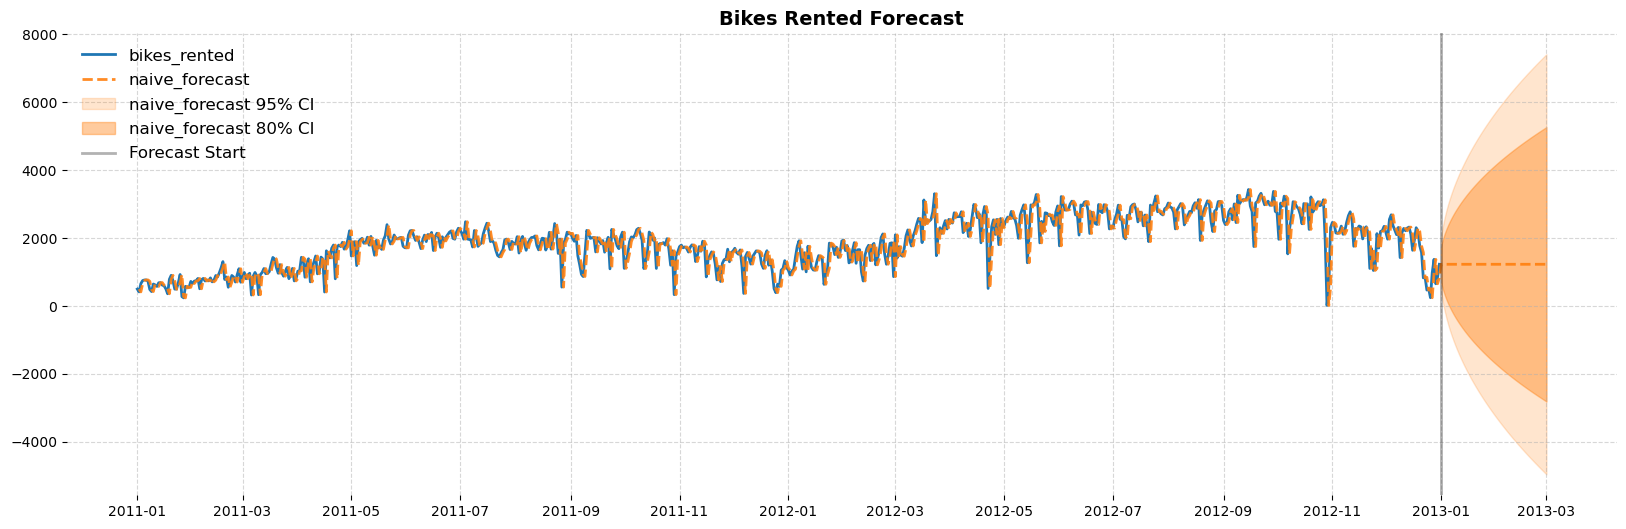

1       415.834439
2       659.495676
3       750.805907
4       766.938328
5       769.481456
          ...     
726     981.195783
727    1374.491192
728     656.034969
729     849.465702
730    1229.748625
Name: bikes_rented, Length: 730, dtype: float64

1       499.329506
2       415.834439
3       659.495676
4       750.805907
5       766.938328
          ...     
726     245.156186
727     981.195783
728    1374.491192
729     656.034969
730     849.465702
Name: naive_forecast, Length: 730, dtype: float64

0      1993.824434
1      1850.678644
2      1861.624232
3      2027.065130
4      1793.546925
          ...     
116    2121.914093
117    2143.038679
118    1998.684336
119    1907.579274
120    2078.094065
Name: bikes_rented, Length: 121, dtype: float64

0      1954.138935
1      1993.824434
2      1850.678644
3      1861.624232
4      2027.065130
          ...     
116    2175.968103
117    2121.914093
118    2143.038679
119    1998.684336
120    1907.579274
Name: naive_forecast, Length: 121, dtype: float64

0      1474.539340
1      1222.175326
2       932.603551
3       868.678694
4      1549.376744
          ...     
116    1336.728464
117    1132.008036
118    1054.720145
119     913.985515
120    1031.104802
Name: bikes_rented, Length: 121, dtype: float64

0      2078.094065
1      1474.539340
2      1222.175326
3       932.603551
4       868.678694
          ...     
116    1106.998165
117    1336.728464
118    1132.008036
119    1054.720145
120     913.985515
Name: naive_forecast, Length: 121, dtype: float64

0      1084.749683
1      1443.763151
2      1761.661595
3      1921.487566
4      1503.291203
          ...     
116    2577.911328
117    2311.444535
118    2372.943079
119    2529.051249
120    2620.158319
Name: bikes_rented, Length: 121, dtype: float64

0      1031.104802
1      1084.749683
2      1443.763151
3      1761.661595
4      1921.487566
          ...     
116    1807.946704
117    2577.911328
118    2311.444535
119    2372.943079
120    2529.051249
Name: naive_forecast, Length: 121, dtype: float64

0      2575.019332
1      2786.122833
2      2597.782279
3      2566.702461
4      2368.557338
          ...     
116    2842.223240
117    3075.450674
118    3081.100828
119    2952.571384
120    2518.539239
Name: bikes_rented, Length: 121, dtype: float64

0      2620.158319
1      2575.019332
2      2786.122833
3      2597.782279
4      2566.702461
          ...     
116    2798.284477
117    2842.223240
118    3075.450674
119    3081.100828
120    2952.571384
Name: naive_forecast, Length: 121, dtype: float64

0      2398.505404
1      2480.066663
2      2779.323579
3      2867.901997
4      2541.368361
          ...     
116     981.195783
117    1374.491192
118     656.034969
119     849.465702
120    1229.748625
Name: bikes_rented, Length: 121, dtype: float64

0      2518.539239
1      2398.505404
2      2480.066663
3      2779.323579
4      2867.901997
          ...     
116     245.156186
117     981.195783
118    1374.491192
119     656.034969
120     849.465702
Name: naive_forecast, Length: 121, dtype: float64

0     1473.372177
1      948.287445
2     1000.871043
3     1441.812404
4     1386.656140
5      413.076599
6     1626.430172
7     1504.843287
8     1417.203048
9     1703.006245
10    1796.200655
11     802.021838
12    1738.078474
13    1796.958769
14    1752.157299
15    1875.953934
16    1675.492089
17    1746.451467
18    1949.264582
19    2215.839655
20    1474.539340
21    1876.330837
22    1895.163321
23    1191.419797
24    1888.386475
25    1954.138935
26    1993.824434
27    1850.678644
28    1861.624232
29    2027.065130
Name: bikes_rented, dtype: float64

0     1295.659756
1     1473.372177
2      948.287445
3     1000.871043
4     1441.812404
5     1386.656140
6      413.076599
7     1626.430172
8     1504.843287
9     1417.203048
10    1703.006245
11    1796.200655
12     802.021838
13    1738.078474
14    1796.958769
15    1752.157299
16    1875.953934
17    1675.492089
18    1746.451467
19    1949.264582
20    2215.839655
21    1474.539340
22    1876.330837
23    1895.163321
24    1191.419797
25    1888.386475
26    1954.138935
27    1993.824434
28    1850.678644
29    1861.624232
Name: naive_forecast, dtype: float64

0     1793.546925
1     2049.806664
2     1764.321588
3     1497.080757
4     1933.505687
5     1708.349407
6     1771.159151
7     1668.987045
8     1941.762444
9     2069.538779
10    2396.680716
11    1973.620407
12    1828.383661
13    1910.587600
14    2092.218750
15    1979.983856
16    1980.732320
17    2010.267072
18    2021.467819
19    1761.661595
20    1717.504007
21    1714.453189
22    2088.502947
23    2215.839655
24    2226.898284
25    2065.445477
26    1931.628504
27    2038.253662
28    1876.330837
29    1691.931239
Name: bikes_rented, dtype: float64

0     2027.065130
1     1793.546925
2     2049.806664
3     1764.321588
4     1497.080757
5     1933.505687
6     1708.349407
7     1771.159151
8     1668.987045
9     1941.762444
10    2069.538779
11    2396.680716
12    1973.620407
13    1828.383661
14    1910.587600
15    2092.218750
16    1979.983856
17    1980.732320
18    2010.267072
19    2021.467819
20    1761.661595
21    1717.504007
22    1714.453189
23    2088.502947
24    2215.839655
25    2226.898284
26    2065.445477
27    1931.628504
28    2038.253662
29    1876.330837
Name: naive_forecast, dtype: float64

0     1945.889091
1     2087.759682
2     1898.550548
3     2107.815669
4     2059.861981
5     2167.094753
6     1635.260175
7     2042.354098
8     2144.520075
9     2005.037249
10    1728.176271
11    2038.999276
12    1916.226532
13    2022.214245
14    2097.047997
15    2175.228839
16    2213.258264
17    1991.580876
18    1969.126937
19    2183.728380
20    2290.530240
21    2234.266690
22    2144.520075
23    1969.501444
24    2483.336238
25    1975.492290
26    1962.009514
27    1948.139504
28    1739.601230
29    2224.687137
Name: bikes_rented, dtype: float64

0     1691.931239
1     1945.889091
2     2087.759682
3     1898.550548
4     2107.815669
5     2059.861981
6     2167.094753
7     1635.260175
8     2042.354098
9     2144.520075
10    2005.037249
11    1728.176271
12    2038.999276
13    1916.226532
14    2022.214245
15    2097.047997
16    2175.228839
17    2213.258264
18    1991.580876
19    1969.126937
20    2183.728380
21    2290.530240
22    2234.266690
23    2144.520075
24    1969.501444
25    2483.336238
26    1975.492290
27    1962.009514
28    1948.139504
29    1739.601230
Name: naive_forecast, dtype: float64

0     2056.138544
1     1757.100377
2     1822.331413
3     1854.076460
4     2131.553284
5     2298.972352
6     2439.694987
7     2212.151833
8     1897.797900
9     1929.000046
10    1850.301058
11    1641.782669
12    1488.535855
13    1448.833472
14    1573.316109
15    1663.244531
16    1947.389404
17    1972.122734
18    1872.184360
19    1665.541849
20    1904.194162
21    1838.968763
22    1825.357867
23    2042.726811
24    1560.966337
25    1942.137642
26    2050.551725
27    1835.945267
28    1642.166239
29    1848.035331
Name: bikes_rented, dtype: float64

0     2224.687137
1     2056.138544
2     1757.100377
3     1822.331413
4     1854.076460
5     2131.553284
6     2298.972352
7     2439.694987
8     2212.151833
9     1897.797900
10    1929.000046
11    1850.301058
12    1641.782669
13    1488.535855
14    1448.833472
15    1573.316109
16    1663.244531
17    1947.389404
18    1972.122734
19    1872.184360
20    1665.541849
21    1904.194162
22    1838.968763
23    1825.357867
24    2042.726811
25    1560.966337
26    1942.137642
27    2050.551725
28    1835.945267
29    1642.166239
Name: naive_forecast, dtype: float64

0     1951.889432
1     2018.481754
2     2022.960635
3     2065.073306
4     1781.408995
5     1655.583785
6     1852.566421
7     1997.936760
8     1986.344615
9     1649.835166
10    1782.547387
11    2171.162297
12    1675.874635
13    2010.267072
14    2429.497301
15    2148.593220
16    1548.603700
17    1973.994803
18     557.212401
19    1851.056220
20    1963.882849
21    2175.968103
22    2121.914093
23    2143.038679
24    1998.684336
25    1907.579274
26    2078.094065
27    1474.539340
28    1222.175326
29     932.603551
Name: bikes_rented, dtype: float64

0     1848.035331
1     1951.889432
2     2018.481754
3     2022.960635
4     2065.073306
5     1781.408995
6     1655.583785
7     1852.566421
8     1997.936760
9     1986.344615
10    1649.835166
11    1782.547387
12    2171.162297
13    1675.874635
14    2010.267072
15    2429.497301
16    2148.593220
17    1548.603700
18    1973.994803
19     557.212401
20    1851.056220
21    1963.882849
22    2175.968103
23    2121.914093
24    2143.038679
25    1998.684336
26    1907.579274
27    2078.094065
28    1474.539340
29    1222.175326
Name: naive_forecast, dtype: float64

0      868.678694
1     1549.376744
2     2228.003749
3     2117.463294
4     1993.450530
5     2012.134433
6     2020.348113
7     1593.742464
8     2011.014044
9     1917.729878
10    1828.383661
11    1928.248972
12    1586.809094
13    1857.850850
14    2024.080151
15    1095.679086
16    2256.720650
17    2104.103498
18    1962.384199
19    1770.019799
20    1688.874389
21    2040.490398
22    2175.228839
23    1109.421698
24    1304.756825
25    1559.421713
26    1897.045212
27    2035.643729
28    2012.881313
29    2094.819296
Name: bikes_rented, dtype: float64

0      932.603551
1      868.678694
2     1549.376744
3     2228.003749
4     2117.463294
5     1993.450530
6     2012.134433
7     2020.348113
8     1593.742464
9     2011.014044
10    1917.729878
11    1828.383661
12    1928.248972
13    1586.809094
14    1857.850850
15    2024.080151
16    1095.679086
17    2256.720650
18    2104.103498
19    1962.384199
20    1770.019799
21    1688.874389
22    2040.490398
23    2175.228839
24    1109.421698
25    1304.756825
26    1559.421713
27    1897.045212
28    2035.643729
29    2012.881313
Name: naive_forecast, dtype: float64

0     2251.569891
1     2289.061630
2     2143.779394
3     1937.259332
4     1104.169828
5     1302.779913
6     1587.964932
7     2180.772513
8     2115.608431
9     1939.886315
10    2006.531667
11    1107.402135
12    1798.474871
13    1839.724534
14    1841.235955
15    1868.790890
16    1795.442499
17    1983.725804
18    1683.905454
19    1201.816326
20    1627.582268
21     334.791072
22    1466.755952
23    1597.592622
24    1750.255627
25    1795.063405
26    1714.453189
27    1741.885036
28    1696.133222
29    1589.891083
Name: bikes_rented, dtype: float64

0     2094.819296
1     2251.569891
2     2289.061630
3     2143.779394
4     1937.259332
5     1104.169828
6     1302.779913
7     1587.964932
8     2180.772513
9     2115.608431
10    1939.886315
11    2006.531667
12    1107.402135
13    1798.474871
14    1839.724534
15    1841.235955
16    1868.790890
17    1795.442499
18    1983.725804
19    1683.905454
20    1201.816326
21    1627.582268
22     334.791072
23    1466.755952
24    1597.592622
25    1750.255627
26    1795.063405
27    1714.453189
28    1741.885036
29    1696.133222
Name: naive_forecast, dtype: float64

0     1737.697757
1     1802.264389
2     1765.841347
3     1310.685202
4     1481.150972
5     1749.875260
6     1616.056462
7     1908.331414
8     1798.474871
9      858.243860
10    1357.987008
11    1490.478443
12    1595.282674
13    1540.096859
14    1244.081267
15     769.905204
16    1164.573377
17     722.249826
18    1254.816503
19    1363.884372
20    1365.063442
21    1673.579186
22    1303.175327
23    1576.015920
24    1619.899595
25    1701.479222
26    1576.401557
27    1526.550484
28    1652.134930
29    1175.802569
Name: bikes_rented, dtype: float64

0     1589.891083
1     1737.697757
2     1802.264389
3     1765.841347
4     1310.685202
5     1481.150972
6     1749.875260
7     1616.056462
8     1908.331414
9     1798.474871
10     858.243860
11    1357.987008
12    1490.478443
13    1595.282674
14    1540.096859
15    1244.081267
16     769.905204
17    1164.573377
18     722.249826
19    1254.816503
20    1363.884372
21    1365.063442
22    1673.579186
23    1303.175327
24    1576.015920
25    1619.899595
26    1701.479222
27    1576.401557
28    1526.550484
29    1652.134930
Name: naive_forecast, dtype: float64

0      371.406602
1     1463.251657
2     1578.715122
3     1411.726696
4     1235.325026
5     1458.577545
6     1541.257246
7     1624.893876
8     1612.981090
9     1562.124672
10    1233.732107
11    1110.229387
12    1494.750967
13    1628.734257
14    1202.215956
15    1363.884372
16    1020.087248
17     510.973685
18     394.165529
19     645.638382
20     577.941913
21    1057.971950
22    1106.998165
23    1336.728464
24    1132.008036
25    1054.720145
26     913.985515
27    1031.104802
28    1084.749683
29    1443.763151
Name: bikes_rented, dtype: float64

0     1175.802569
1      371.406602
2     1463.251657
3     1578.715122
4     1411.726696
5     1235.325026
6     1458.577545
7     1541.257246
8     1624.893876
9     1612.981090
10    1562.124672
11    1233.732107
12    1110.229387
13    1494.750967
14    1628.734257
15    1202.215956
16    1363.884372
17    1020.087248
18     510.973685
19     394.165529
20     645.638382
21     577.941913
22    1057.971950
23    1106.998165
24    1336.728464
25    1132.008036
26    1054.720145
27     913.985515
28    1031.104802
29    1084.749683
Name: naive_forecast, dtype: float64

0     1761.661595
1     1921.487566
2     1503.291203
3     1087.989528
4     1570.229865
5     1007.009102
6     1761.281553
7     1421.113024
8     1135.229797
9     1061.628660
10    1056.346212
11    1311.475386
12    1484.260985
13    1451.562679
14    1401.157255
15     638.695106
16     924.748618
17    1110.633203
18    1852.943946
19    1826.870846
20    1752.917892
21    1515.314362
22    1733.128303
23    1432.443975
24    1580.257251
25    1916.978224
26    1943.263176
27    1632.957302
28    1781.788470
29    1270.698422
Name: bikes_rented, dtype: float64

0     1443.763151
1     1761.661595
2     1921.487566
3     1503.291203
4     1087.989528
5     1570.229865
6     1007.009102
7     1761.281553
8     1421.113024
9     1135.229797
10    1061.628660
11    1056.346212
12    1311.475386
13    1484.260985
14    1451.562679
15    1401.157255
16     638.695106
17     924.748618
18    1110.633203
19    1852.943946
20    1826.870846
21    1752.917892
22    1515.314362
23    1733.128303
24    1432.443975
25    1580.257251
26    1916.978224
27    1943.263176
28    1632.957302
29    1781.788470
Name: naive_forecast, dtype: float64

0     1316.215174
1     1641.782669
2     1866.528126
3     1258.789449
4     1659.414740
5     1659.797771
6     1003.736085
7      736.759152
8     1502.127002
9     1694.605387
10    1788.617198
11    1339.092708
12    1782.926830
13    1845.013793
14    1213.797651
15    1387.832646
16    1639.097349
17    2015.868469
18    2123.397420
19    1527.324987
20    1230.943847
21    1489.312930
22    1846.524643
23    1862.001515
24     865.341349
25    2096.676569
26    1413.291653
27    1749.494882
28    1502.515082
29    1467.534535
Name: bikes_rented, dtype: float64

0     1270.698422
1     1316.215174
2     1641.782669
3     1866.528126
4     1258.789449
5     1659.414740
6     1659.797771
7     1003.736085
8      736.759152
9     1502.127002
10    1694.605387
11    1788.617198
12    1339.092708
13    1782.926830
14    1845.013793
15    1213.797651
16    1387.832646
17    1639.097349
18    2015.868469
19    2123.397420
20    1527.324987
21    1230.943847
22    1489.312930
23    1846.524643
24    1862.001515
25     865.341349
26    2096.676569
27    1413.291653
28    1749.494882
29    1502.515082
Name: naive_forecast, dtype: float64

0     1707.586233
1     2069.166705
2     2241.631901
3     1939.511060
4     1769.260177
5     2067.306201
6     2210.676477
7     2412.002430
8     2580.802897
9     2537.384274
10    1867.659553
11    3124.491112
12    2428.404358
13    2523.252231
14    2501.490254
15    2551.144004
16    2781.828821
17    3309.169996
18    1482.706086
19    2098.905010
20    2306.310005
21    2138.223212
22    2357.588303
23    2516.000993
24    2269.958372
25    2552.953767
26    2482.609715
27    2444.427719
28    2746.369790
29    2625.568094
Name: bikes_rented, dtype: float64

0     1467.534535
1     1707.586233
2     2069.166705
3     2241.631901
4     1939.511060
5     1769.260177
6     2067.306201
7     2210.676477
8     2412.002430
9     2580.802897
10    2537.384274
11    1867.659553
12    3124.491112
13    2428.404358
14    2523.252231
15    2501.490254
16    2551.144004
17    2781.828821
18    3309.169996
19    1482.706086
20    2098.905010
21    2306.310005
22    2138.223212
23    2357.588303
24    2516.000993
25    2269.958372
26    2552.953767
27    2482.609715
28    2444.427719
29    2746.369790
Name: naive_forecast, dtype: float64

0     2633.139317
1     2634.220686
2     2776.818039
3     2163.026204
4     2316.210969
5     2437.874383
6     2049.061568
7     2251.569891
8     2611.860474
9     2991.596053
10    2875.029608
11    2601.754066
12    2717.313024
13    1863.510546
14    2672.032039
15    2931.256621
16    2693.247505
17     518.122001
18    1421.113024
19    2333.798963
20    2538.833128
21    2110.042558
22    2552.229882
23    1807.946704
24    2577.911328
25    2311.444535
26    2372.943079
27    2529.051249
28    2620.158319
29    2575.019332
Name: bikes_rented, dtype: float64

0     2625.568094
1     2633.139317
2     2634.220686
3     2776.818039
4     2163.026204
5     2316.210969
6     2437.874383
7     2049.061568
8     2251.569891
9     2611.860474
10    2991.596053
11    2875.029608
12    2601.754066
13    2717.313024
14    1863.510546
15    2672.032039
16    2931.256621
17    2693.247505
18     518.122001
19    1421.113024
20    2333.798963
21    2538.833128
22    2110.042558
23    2552.229882
24    1807.946704
25    2577.911328
26    2311.444535
27    2372.943079
28    2529.051249
29    2620.158319
Name: naive_forecast, dtype: float64

0     2786.122833
1     2597.782279
2     2566.702461
3     2368.557338
4     1994.946088
5     2674.550283
6     2838.654337
7     2980.605005
8     2510.560759
9     1275.061363
10    2143.038679
11    2978.831757
12    2964.640760
13    3054.957391
14    3285.372983
15    2873.960615
16    1860.492324
17    2494.230734
18    2196.654127
19    2745.652828
20    2732.743283
21    2661.595980
22    2681.383948
23    2483.336238
24    2374.039348
25    2776.102116
26    2948.310055
27    1772.678138
28    3224.376771
29    3055.664356
Name: bikes_rented, dtype: float64

0     2575.019332
1     2786.122833
2     2597.782279
3     2566.702461
4     2368.557338
5     1994.946088
6     2674.550283
7     2838.654337
8     2980.605005
9     2510.560759
10    1275.061363
11    2143.038679
12    2978.831757
13    2964.640760
14    3054.957391
15    3285.372983
16    2873.960615
17    1860.492324
18    2494.230734
19    2196.654127
20    2745.652828
21    2732.743283
22    2661.595980
23    2681.383948
24    2483.336238
25    2374.039348
26    2776.102116
27    2948.310055
28    1772.678138
29    3224.376771
Name: naive_forecast, dtype: float64

0     2827.229875
1     2828.301176
2     2847.575489
3     3003.644645
4     3089.220538
5     3005.061708
6     2683.901036
7     2707.618366
8     2089.989373
9     2977.767741
10    2957.186910
11    3064.146264
12    3077.216494
13    2820.086503
14    2137.111747
15    2765.360350
16    2544.265363
17    2433.139977
18    2403.248738
19    2990.887113
20    2788.985023
21    2748.878965
22    2985.214802
23    2947.244596
24    2784.691592
25    2271.428602
26    2353.564643
27    2296.403446
28    2550.058065
29    2706.181732
Name: bikes_rented, dtype: float64

0     3055.664356
1     2827.229875
2     2828.301176
3     2847.575489
4     3003.644645
5     3089.220538
6     3005.061708
7     2683.901036
8     2707.618366
9     2089.989373
10    2977.767741
11    2957.186910
12    3064.146264
13    3077.216494
14    2820.086503
15    2137.111747
16    2765.360350
17    2544.265363
18    2433.139977
19    2403.248738
20    2990.887113
21    2788.985023
22    2748.878965
23    2985.214802
24    2947.244596
25    2784.691592
26    2271.428602
27    2353.564643
28    2296.403446
29    2550.058065
Name: naive_forecast, dtype: float64

0     2971.382595
1     2555.125260
2     2542.816916
3     2040.863156
4     1978.112533
5     2673.471074
6     2572.850055
7     2922.013896
8     2986.633013
9     3005.415960
10    2816.871208
11    2478.976679
12    2767.151025
13    2751.387839
14    2363.073658
15    2681.383948
16    2420.387465
17    1898.174229
18    2973.865922
19    2815.799337
20    3038.337494
21    3242.972030
22    2778.249812
23    2793.635259
24    2715.159049
25    2683.541471
26    2865.406782
27    2904.940283
28    3034.092201
29    2920.947180
Name: bikes_rented, dtype: float64

0     2706.181732
1     2971.382595
2     2555.125260
3     2542.816916
4     2040.863156
5     1978.112533
6     2673.471074
7     2572.850055
8     2922.013896
9     2986.633013
10    3005.415960
11    2816.871208
12    2478.976679
13    2767.151025
14    2751.387839
15    2363.073658
16    2681.383948
17    2420.387465
18    1898.174229
19    2973.865922
20    2815.799337
21    3038.337494
22    3242.972030
23    2778.249812
24    2793.635259
25    2715.159049
26    2683.541471
27    2865.406782
28    2904.940283
29    3034.092201
Name: naive_forecast, dtype: float64

0     2890.346113
1     2765.002196
2     2271.796140
3     2832.585846
4     2925.213735
5     3017.811325
6     2929.834913
7     2389.745235
8     2576.103880
9     2664.475429
10    2786.122833
11    2750.671049
12    2951.506127
13    3042.935680
14    2880.730024
15    3134.709761
16    1932.003960
17    2659.436124
18    2830.086559
19    2961.446555
20    3099.454433
21    3034.799804
22    2486.968434
23    2194.808206
24    2798.284477
25    2842.223240
26    3075.450674
27    3081.100828
28    2952.571384
29    2518.539239
Name: bikes_rented, dtype: float64

0     2920.947180
1     2890.346113
2     2765.002196
3     2271.796140
4     2832.585846
5     2925.213735
6     3017.811325
7     2929.834913
8     2389.745235
9     2576.103880
10    2664.475429
11    2786.122833
12    2750.671049
13    2951.506127
14    3042.935680
15    2880.730024
16    3134.709761
17    1932.003960
18    2659.436124
19    2830.086559
20    2961.446555
21    3099.454433
22    3034.799804
23    2486.968434
24    2194.808206
25    2798.284477
26    2842.223240
27    3075.450674
28    3081.100828
29    2952.571384
Name: naive_forecast, dtype: float64

0     2398.505404
1     2480.066663
2     2779.323579
3     2867.901997
4     2541.368361
5     3007.187138
6     2458.982428
7     3261.903725
8     3014.624586
9     3100.160055
10    3136.471154
11    3113.210255
12    3185.386109
13    3431.999384
14    2946.534262
15    2781.113068
16    1752.157299
17    3037.983749
18    3083.572342
19    3240.867611
20    3320.710427
21    3149.501423
22    2983.087320
23    3019.227511
24    3088.161605
25    2967.834512
26    2975.639560
27    3376.589668
28    2788.269512
29    2748.520530
Name: bikes_rented, dtype: float64

0     2518.539239
1     2398.505404
2     2480.066663
3     2779.323579
4     2867.901997
5     2541.368361
6     3007.187138
7     2458.982428
8     3261.903725
9     3014.624586
10    3100.160055
11    3136.471154
12    3113.210255
13    3185.386109
14    3431.999384
15    2946.534262
16    2781.113068
17    1752.157299
18    3037.983749
19    3083.572342
20    3240.867611
21    3320.710427
22    3149.501423
23    2983.087320
24    3019.227511
25    3088.161605
26    2967.834512
27    2975.639560
28    3376.589668
29    2788.269512
Name: naive_forecast, dtype: float64

0     1965.755948
1     3031.261571
2     2944.758329
3     3237.009045
4     3169.912998
5     1536.228071
6     2276.940851
7     2609.695249
8     3073.331514
9     3030.553860
10    2928.413114
11    2866.832654
12    2698.637757
13    2422.209792
14    3017.811325
15    2991.950514
16    3008.958178
17    2257.088503
18    3213.844902
19    2765.002196
20    2848.645780
21    2993.722738
22    3074.037922
23    2955.766849
24    2985.923919
25    3130.129530
26    1898.174229
27      16.942177
28     548.803757
29    2309.244206
Name: bikes_rented, dtype: float64

0     2748.520530
1     1965.755948
2     3031.261571
3     2944.758329
4     3237.009045
5     3169.912998
6     1536.228071
7     2276.940851
8     2609.695249
9     3073.331514
10    3030.553860
11    2928.413114
12    2866.832654
13    2698.637757
14    2422.209792
15    3017.811325
16    2991.950514
17    3008.958178
18    2257.088503
19    3213.844902
20    2765.002196
21    2848.645780
22    2993.722738
23    3074.037922
24    2955.766849
25    2985.923919
26    3130.129530
27    1898.174229
28      16.942177
29     548.803757
Name: naive_forecast, dtype: float64

0     2462.619333
1     2412.002430
2     2151.554869
3     2140.075483
4     2196.284959
5     2353.198811
6     2113.382314
7     2216.945844
8     2464.801136
9     2661.595980
10    2775.028186
11    2565.255687
12    1760.141361
13    2283.185946
14    2264.811579
15    2357.588303
16    2332.333964
17    1976.989628
18    2284.655053
19    2334.165194
20    2154.515982
21    1107.806087
22    1690.020793
23    1047.805676
24    1107.402135
25    2132.665129
26    1708.730978
27    2196.654127
28    2219.895327
29    2346.612551
Name: bikes_rented, dtype: float64

0     2309.244206
1     2462.619333
2     2412.002430
3     2151.554869
4     2140.075483
5     2196.284959
6     2353.198811
7     2113.382314
8     2216.945844
9     2464.801136
10    2661.595980
11    2775.028186
12    2565.255687
13    1760.141361
14    2283.185946
15    2264.811579
16    2357.588303
17    2332.333964
18    1976.989628
19    2284.655053
20    2334.165194
21    2154.515982
22    1107.806087
23    1690.020793
24    1047.805676
25    1107.402135
26    2132.665129
27    1708.730978
28    2196.654127
29    2219.895327
Name: naive_forecast, dtype: float64

0     2171.162297
1     1969.501444
2     2552.591828
3     2686.777328
4     2368.922857
5     2239.054440
6     2103.360960
7     2315.111137
8     1426.584616
9     2163.396114
10    2285.389560
11    2218.420650
12    2296.770456
13    2325.739971
14    2117.834241
15    1642.549797
16    1945.513989
17    2305.943195
18    2199.238074
19    1773.057858
20    1579.871738
21     829.775849
22     845.699988
23     470.060174
24     511.867939
25     245.156186
26     981.195783
27    1374.491192
28     656.034969
29     849.465702
Name: bikes_rented, dtype: float64

0     2346.612551
1     2171.162297
2     1969.501444
3     2552.591828
4     2686.777328
5     2368.922857
6     2239.054440
7     2103.360960
8     2315.111137
9     1426.584616
10    2163.396114
11    2285.389560
12    2218.420650
13    2296.770456
14    2325.739971
15    2117.834241
16    1642.549797
17    1945.513989
18    2305.943195
19    2199.238074
20    1773.057858
21    1579.871738
22     829.775849
23     845.699988
24     470.060174
25     511.867939
26     245.156186
27     981.195783
28    1374.491192
29     656.034969
Name: naive_forecast, dtype: float64

0     1473.372177
1      948.287445
2     1000.871043
3     1441.812404
4     1386.656140
5      413.076599
6     1626.430172
7     1504.843287
8     1417.203048
9     1703.006245
10    1796.200655
11     802.021838
12    1738.078474
13    1796.958769
14    1752.157299
15    1875.953934
16    1675.492089
17    1746.451467
18    1949.264582
19    2215.839655
20    1474.539340
21    1876.330837
22    1895.163321
23    1191.419797
24    1888.386475
25    1954.138935
26    1993.824434
27    1850.678644
28    1861.624232
29    2027.065130
Name: bikes_rented, dtype: float64

0     1295.659756
1     1473.372177
2      948.287445
3     1000.871043
4     1441.812404
5     1386.656140
6      413.076599
7     1626.430172
8     1504.843287
9     1417.203048
10    1703.006245
11    1796.200655
12     802.021838
13    1738.078474
14    1796.958769
15    1752.157299
16    1875.953934
17    1675.492089
18    1746.451467
19    1949.264582
20    2215.839655
21    1474.539340
22    1876.330837
23    1895.163321
24    1191.419797
25    1888.386475
26    1954.138935
27    1993.824434
28    1850.678644
29    1861.624232
Name: naive_forecast, dtype: float64

0     1793.546925
1     2049.806664
2     1764.321588
3     1497.080757
4     1933.505687
5     1708.349407
6     1771.159151
7     1668.987045
8     1941.762444
9     2069.538779
10    2396.680716
11    1973.620407
12    1828.383661
13    1910.587600
14    2092.218750
15    1979.983856
16    1980.732320
17    2010.267072
18    2021.467819
19    1761.661595
20    1717.504007
21    1714.453189
22    2088.502947
23    2215.839655
24    2226.898284
25    2065.445477
26    1931.628504
27    2038.253662
28    1876.330837
29    1691.931239
Name: bikes_rented, dtype: float64

0     2027.065130
1     1793.546925
2     2049.806664
3     1764.321588
4     1497.080757
5     1933.505687
6     1708.349407
7     1771.159151
8     1668.987045
9     1941.762444
10    2069.538779
11    2396.680716
12    1973.620407
13    1828.383661
14    1910.587600
15    2092.218750
16    1979.983856
17    1980.732320
18    2010.267072
19    2021.467819
20    1761.661595
21    1717.504007
22    1714.453189
23    2088.502947
24    2215.839655
25    2226.898284
26    2065.445477
27    1931.628504
28    2038.253662
29    1876.330837
Name: naive_forecast, dtype: float64

0     1945.889091
1     2087.759682
2     1898.550548
3     2107.815669
4     2059.861981
5     2167.094753
6     1635.260175
7     2042.354098
8     2144.520075
9     2005.037249
10    1728.176271
11    2038.999276
12    1916.226532
13    2022.214245
14    2097.047997
15    2175.228839
16    2213.258264
17    1991.580876
18    1969.126937
19    2183.728380
20    2290.530240
21    2234.266690
22    2144.520075
23    1969.501444
24    2483.336238
25    1975.492290
26    1962.009514
27    1948.139504
28    1739.601230
29    2224.687137
Name: bikes_rented, dtype: float64

0     1691.931239
1     1945.889091
2     2087.759682
3     1898.550548
4     2107.815669
5     2059.861981
6     2167.094753
7     1635.260175
8     2042.354098
9     2144.520075
10    2005.037249
11    1728.176271
12    2038.999276
13    1916.226532
14    2022.214245
15    2097.047997
16    2175.228839
17    2213.258264
18    1991.580876
19    1969.126937
20    2183.728380
21    2290.530240
22    2234.266690
23    2144.520075
24    1969.501444
25    2483.336238
26    1975.492290
27    1962.009514
28    1948.139504
29    1739.601230
Name: naive_forecast, dtype: float64

0     2056.138544
1     1757.100377
2     1822.331413
3     1854.076460
4     2131.553284
5     2298.972352
6     2439.694987
7     2212.151833
8     1897.797900
9     1929.000046
10    1850.301058
11    1641.782669
12    1488.535855
13    1448.833472
14    1573.316109
15    1663.244531
16    1947.389404
17    1972.122734
18    1872.184360
19    1665.541849
20    1904.194162
21    1838.968763
22    1825.357867
23    2042.726811
24    1560.966337
25    1942.137642
26    2050.551725
27    1835.945267
28    1642.166239
29    1848.035331
Name: bikes_rented, dtype: float64

0     2224.687137
1     2056.138544
2     1757.100377
3     1822.331413
4     1854.076460
5     2131.553284
6     2298.972352
7     2439.694987
8     2212.151833
9     1897.797900
10    1929.000046
11    1850.301058
12    1641.782669
13    1488.535855
14    1448.833472
15    1573.316109
16    1663.244531
17    1947.389404
18    1972.122734
19    1872.184360
20    1665.541849
21    1904.194162
22    1838.968763
23    1825.357867
24    2042.726811
25    1560.966337
26    1942.137642
27    2050.551725
28    1835.945267
29    1642.166239
Name: naive_forecast, dtype: float64

0     1951.889432
1     2018.481754
2     2022.960635
3     2065.073306
4     1781.408995
5     1655.583785
6     1852.566421
7     1997.936760
8     1986.344615
9     1649.835166
10    1782.547387
11    2171.162297
12    1675.874635
13    2010.267072
14    2429.497301
15    2148.593220
16    1548.603700
17    1973.994803
18     557.212401
19    1851.056220
20    1963.882849
21    2175.968103
22    2121.914093
23    2143.038679
24    1998.684336
25    1907.579274
26    2078.094065
27    1474.539340
28    1222.175326
29     932.603551
Name: bikes_rented, dtype: float64

0     1848.035331
1     1951.889432
2     2018.481754
3     2022.960635
4     2065.073306
5     1781.408995
6     1655.583785
7     1852.566421
8     1997.936760
9     1986.344615
10    1649.835166
11    1782.547387
12    2171.162297
13    1675.874635
14    2010.267072
15    2429.497301
16    2148.593220
17    1548.603700
18    1973.994803
19     557.212401
20    1851.056220
21    1963.882849
22    2175.968103
23    2121.914093
24    2143.038679
25    1998.684336
26    1907.579274
27    2078.094065
28    1474.539340
29    1222.175326
Name: naive_forecast, dtype: float64

0      868.678694
1     1549.376744
2     2228.003749
3     2117.463294
4     1993.450530
5     2012.134433
6     2020.348113
7     1593.742464
8     2011.014044
9     1917.729878
10    1828.383661
11    1928.248972
12    1586.809094
13    1857.850850
14    2024.080151
15    1095.679086
16    2256.720650
17    2104.103498
18    1962.384199
19    1770.019799
20    1688.874389
21    2040.490398
22    2175.228839
23    1109.421698
24    1304.756825
25    1559.421713
26    1897.045212
27    2035.643729
28    2012.881313
29    2094.819296
Name: bikes_rented, dtype: float64

0      932.603551
1      868.678694
2     1549.376744
3     2228.003749
4     2117.463294
5     1993.450530
6     2012.134433
7     2020.348113
8     1593.742464
9     2011.014044
10    1917.729878
11    1828.383661
12    1928.248972
13    1586.809094
14    1857.850850
15    2024.080151
16    1095.679086
17    2256.720650
18    2104.103498
19    1962.384199
20    1770.019799
21    1688.874389
22    2040.490398
23    2175.228839
24    1109.421698
25    1304.756825
26    1559.421713
27    1897.045212
28    2035.643729
29    2012.881313
Name: naive_forecast, dtype: float64

0     2251.569891
1     2289.061630
2     2143.779394
3     1937.259332
4     1104.169828
5     1302.779913
6     1587.964932
7     2180.772513
8     2115.608431
9     1939.886315
10    2006.531667
11    1107.402135
12    1798.474871
13    1839.724534
14    1841.235955
15    1868.790890
16    1795.442499
17    1983.725804
18    1683.905454
19    1201.816326
20    1627.582268
21     334.791072
22    1466.755952
23    1597.592622
24    1750.255627
25    1795.063405
26    1714.453189
27    1741.885036
28    1696.133222
29    1589.891083
Name: bikes_rented, dtype: float64

0     2094.819296
1     2251.569891
2     2289.061630
3     2143.779394
4     1937.259332
5     1104.169828
6     1302.779913
7     1587.964932
8     2180.772513
9     2115.608431
10    1939.886315
11    2006.531667
12    1107.402135
13    1798.474871
14    1839.724534
15    1841.235955
16    1868.790890
17    1795.442499
18    1983.725804
19    1683.905454
20    1201.816326
21    1627.582268
22     334.791072
23    1466.755952
24    1597.592622
25    1750.255627
26    1795.063405
27    1714.453189
28    1741.885036
29    1696.133222
Name: naive_forecast, dtype: float64

0     1737.697757
1     1802.264389
2     1765.841347
3     1310.685202
4     1481.150972
5     1749.875260
6     1616.056462
7     1908.331414
8     1798.474871
9      858.243860
10    1357.987008
11    1490.478443
12    1595.282674
13    1540.096859
14    1244.081267
15     769.905204
16    1164.573377
17     722.249826
18    1254.816503
19    1363.884372
20    1365.063442
21    1673.579186
22    1303.175327
23    1576.015920
24    1619.899595
25    1701.479222
26    1576.401557
27    1526.550484
28    1652.134930
29    1175.802569
Name: bikes_rented, dtype: float64

0     1589.891083
1     1737.697757
2     1802.264389
3     1765.841347
4     1310.685202
5     1481.150972
6     1749.875260
7     1616.056462
8     1908.331414
9     1798.474871
10     858.243860
11    1357.987008
12    1490.478443
13    1595.282674
14    1540.096859
15    1244.081267
16     769.905204
17    1164.573377
18     722.249826
19    1254.816503
20    1363.884372
21    1365.063442
22    1673.579186
23    1303.175327
24    1576.015920
25    1619.899595
26    1701.479222
27    1576.401557
28    1526.550484
29    1652.134930
Name: naive_forecast, dtype: float64

0      371.406602
1     1463.251657
2     1578.715122
3     1411.726696
4     1235.325026
5     1458.577545
6     1541.257246
7     1624.893876
8     1612.981090
9     1562.124672
10    1233.732107
11    1110.229387
12    1494.750967
13    1628.734257
14    1202.215956
15    1363.884372
16    1020.087248
17     510.973685
18     394.165529
19     645.638382
20     577.941913
21    1057.971950
22    1106.998165
23    1336.728464
24    1132.008036
25    1054.720145
26     913.985515
27    1031.104802
28    1084.749683
29    1443.763151
Name: bikes_rented, dtype: float64

0     1175.802569
1      371.406602
2     1463.251657
3     1578.715122
4     1411.726696
5     1235.325026
6     1458.577545
7     1541.257246
8     1624.893876
9     1612.981090
10    1562.124672
11    1233.732107
12    1110.229387
13    1494.750967
14    1628.734257
15    1202.215956
16    1363.884372
17    1020.087248
18     510.973685
19     394.165529
20     645.638382
21     577.941913
22    1057.971950
23    1106.998165
24    1336.728464
25    1132.008036
26    1054.720145
27     913.985515
28    1031.104802
29    1084.749683
Name: naive_forecast, dtype: float64

0     1761.661595
1     1921.487566
2     1503.291203
3     1087.989528
4     1570.229865
5     1007.009102
6     1761.281553
7     1421.113024
8     1135.229797
9     1061.628660
10    1056.346212
11    1311.475386
12    1484.260985
13    1451.562679
14    1401.157255
15     638.695106
16     924.748618
17    1110.633203
18    1852.943946
19    1826.870846
20    1752.917892
21    1515.314362
22    1733.128303
23    1432.443975
24    1580.257251
25    1916.978224
26    1943.263176
27    1632.957302
28    1781.788470
29    1270.698422
Name: bikes_rented, dtype: float64

0     1443.763151
1     1761.661595
2     1921.487566
3     1503.291203
4     1087.989528
5     1570.229865
6     1007.009102
7     1761.281553
8     1421.113024
9     1135.229797
10    1061.628660
11    1056.346212
12    1311.475386
13    1484.260985
14    1451.562679
15    1401.157255
16     638.695106
17     924.748618
18    1110.633203
19    1852.943946
20    1826.870846
21    1752.917892
22    1515.314362
23    1733.128303
24    1432.443975
25    1580.257251
26    1916.978224
27    1943.263176
28    1632.957302
29    1781.788470
Name: naive_forecast, dtype: float64

0     1316.215174
1     1641.782669
2     1866.528126
3     1258.789449
4     1659.414740
5     1659.797771
6     1003.736085
7      736.759152
8     1502.127002
9     1694.605387
10    1788.617198
11    1339.092708
12    1782.926830
13    1845.013793
14    1213.797651
15    1387.832646
16    1639.097349
17    2015.868469
18    2123.397420
19    1527.324987
20    1230.943847
21    1489.312930
22    1846.524643
23    1862.001515
24     865.341349
25    2096.676569
26    1413.291653
27    1749.494882
28    1502.515082
29    1467.534535
Name: bikes_rented, dtype: float64

0     1270.698422
1     1316.215174
2     1641.782669
3     1866.528126
4     1258.789449
5     1659.414740
6     1659.797771
7     1003.736085
8      736.759152
9     1502.127002
10    1694.605387
11    1788.617198
12    1339.092708
13    1782.926830
14    1845.013793
15    1213.797651
16    1387.832646
17    1639.097349
18    2015.868469
19    2123.397420
20    1527.324987
21    1230.943847
22    1489.312930
23    1846.524643
24    1862.001515
25     865.341349
26    2096.676569
27    1413.291653
28    1749.494882
29    1502.515082
Name: naive_forecast, dtype: float64

0     1707.586233
1     2069.166705
2     2241.631901
3     1939.511060
4     1769.260177
5     2067.306201
6     2210.676477
7     2412.002430
8     2580.802897
9     2537.384274
10    1867.659553
11    3124.491112
12    2428.404358
13    2523.252231
14    2501.490254
15    2551.144004
16    2781.828821
17    3309.169996
18    1482.706086
19    2098.905010
20    2306.310005
21    2138.223212
22    2357.588303
23    2516.000993
24    2269.958372
25    2552.953767
26    2482.609715
27    2444.427719
28    2746.369790
29    2625.568094
Name: bikes_rented, dtype: float64

0     1467.534535
1     1707.586233
2     2069.166705
3     2241.631901
4     1939.511060
5     1769.260177
6     2067.306201
7     2210.676477
8     2412.002430
9     2580.802897
10    2537.384274
11    1867.659553
12    3124.491112
13    2428.404358
14    2523.252231
15    2501.490254
16    2551.144004
17    2781.828821
18    3309.169996
19    1482.706086
20    2098.905010
21    2306.310005
22    2138.223212
23    2357.588303
24    2516.000993
25    2269.958372
26    2552.953767
27    2482.609715
28    2444.427719
29    2746.369790
Name: naive_forecast, dtype: float64

0     2633.139317
1     2634.220686
2     2776.818039
3     2163.026204
4     2316.210969
5     2437.874383
6     2049.061568
7     2251.569891
8     2611.860474
9     2991.596053
10    2875.029608
11    2601.754066
12    2717.313024
13    1863.510546
14    2672.032039
15    2931.256621
16    2693.247505
17     518.122001
18    1421.113024
19    2333.798963
20    2538.833128
21    2110.042558
22    2552.229882
23    1807.946704
24    2577.911328
25    2311.444535
26    2372.943079
27    2529.051249
28    2620.158319
29    2575.019332
Name: bikes_rented, dtype: float64

0     2625.568094
1     2633.139317
2     2634.220686
3     2776.818039
4     2163.026204
5     2316.210969
6     2437.874383
7     2049.061568
8     2251.569891
9     2611.860474
10    2991.596053
11    2875.029608
12    2601.754066
13    2717.313024
14    1863.510546
15    2672.032039
16    2931.256621
17    2693.247505
18     518.122001
19    1421.113024
20    2333.798963
21    2538.833128
22    2110.042558
23    2552.229882
24    1807.946704
25    2577.911328
26    2311.444535
27    2372.943079
28    2529.051249
29    2620.158319
Name: naive_forecast, dtype: float64

0     2786.122833
1     2597.782279
2     2566.702461
3     2368.557338
4     1994.946088
5     2674.550283
6     2838.654337
7     2980.605005
8     2510.560759
9     1275.061363
10    2143.038679
11    2978.831757
12    2964.640760
13    3054.957391
14    3285.372983
15    2873.960615
16    1860.492324
17    2494.230734
18    2196.654127
19    2745.652828
20    2732.743283
21    2661.595980
22    2681.383948
23    2483.336238
24    2374.039348
25    2776.102116
26    2948.310055
27    1772.678138
28    3224.376771
29    3055.664356
Name: bikes_rented, dtype: float64

0     2575.019332
1     2786.122833
2     2597.782279
3     2566.702461
4     2368.557338
5     1994.946088
6     2674.550283
7     2838.654337
8     2980.605005
9     2510.560759
10    1275.061363
11    2143.038679
12    2978.831757
13    2964.640760
14    3054.957391
15    3285.372983
16    2873.960615
17    1860.492324
18    2494.230734
19    2196.654127
20    2745.652828
21    2732.743283
22    2661.595980
23    2681.383948
24    2483.336238
25    2374.039348
26    2776.102116
27    2948.310055
28    1772.678138
29    3224.376771
Name: naive_forecast, dtype: float64

0     2827.229875
1     2828.301176
2     2847.575489
3     3003.644645
4     3089.220538
5     3005.061708
6     2683.901036
7     2707.618366
8     2089.989373
9     2977.767741
10    2957.186910
11    3064.146264
12    3077.216494
13    2820.086503
14    2137.111747
15    2765.360350
16    2544.265363
17    2433.139977
18    2403.248738
19    2990.887113
20    2788.985023
21    2748.878965
22    2985.214802
23    2947.244596
24    2784.691592
25    2271.428602
26    2353.564643
27    2296.403446
28    2550.058065
29    2706.181732
Name: bikes_rented, dtype: float64

0     3055.664356
1     2827.229875
2     2828.301176
3     2847.575489
4     3003.644645
5     3089.220538
6     3005.061708
7     2683.901036
8     2707.618366
9     2089.989373
10    2977.767741
11    2957.186910
12    3064.146264
13    3077.216494
14    2820.086503
15    2137.111747
16    2765.360350
17    2544.265363
18    2433.139977
19    2403.248738
20    2990.887113
21    2788.985023
22    2748.878965
23    2985.214802
24    2947.244596
25    2784.691592
26    2271.428602
27    2353.564643
28    2296.403446
29    2550.058065
Name: naive_forecast, dtype: float64

0     2971.382595
1     2555.125260
2     2542.816916
3     2040.863156
4     1978.112533
5     2673.471074
6     2572.850055
7     2922.013896
8     2986.633013
9     3005.415960
10    2816.871208
11    2478.976679
12    2767.151025
13    2751.387839
14    2363.073658
15    2681.383948
16    2420.387465
17    1898.174229
18    2973.865922
19    2815.799337
20    3038.337494
21    3242.972030
22    2778.249812
23    2793.635259
24    2715.159049
25    2683.541471
26    2865.406782
27    2904.940283
28    3034.092201
29    2920.947180
Name: bikes_rented, dtype: float64

0     2706.181732
1     2971.382595
2     2555.125260
3     2542.816916
4     2040.863156
5     1978.112533
6     2673.471074
7     2572.850055
8     2922.013896
9     2986.633013
10    3005.415960
11    2816.871208
12    2478.976679
13    2767.151025
14    2751.387839
15    2363.073658
16    2681.383948
17    2420.387465
18    1898.174229
19    2973.865922
20    2815.799337
21    3038.337494
22    3242.972030
23    2778.249812
24    2793.635259
25    2715.159049
26    2683.541471
27    2865.406782
28    2904.940283
29    3034.092201
Name: naive_forecast, dtype: float64

0     2890.346113
1     2765.002196
2     2271.796140
3     2832.585846
4     2925.213735
5     3017.811325
6     2929.834913
7     2389.745235
8     2576.103880
9     2664.475429
10    2786.122833
11    2750.671049
12    2951.506127
13    3042.935680
14    2880.730024
15    3134.709761
16    1932.003960
17    2659.436124
18    2830.086559
19    2961.446555
20    3099.454433
21    3034.799804
22    2486.968434
23    2194.808206
24    2798.284477
25    2842.223240
26    3075.450674
27    3081.100828
28    2952.571384
29    2518.539239
Name: bikes_rented, dtype: float64

0     2920.947180
1     2890.346113
2     2765.002196
3     2271.796140
4     2832.585846
5     2925.213735
6     3017.811325
7     2929.834913
8     2389.745235
9     2576.103880
10    2664.475429
11    2786.122833
12    2750.671049
13    2951.506127
14    3042.935680
15    2880.730024
16    3134.709761
17    1932.003960
18    2659.436124
19    2830.086559
20    2961.446555
21    3099.454433
22    3034.799804
23    2486.968434
24    2194.808206
25    2798.284477
26    2842.223240
27    3075.450674
28    3081.100828
29    2952.571384
Name: naive_forecast, dtype: float64

0     2398.505404
1     2480.066663
2     2779.323579
3     2867.901997
4     2541.368361
5     3007.187138
6     2458.982428
7     3261.903725
8     3014.624586
9     3100.160055
10    3136.471154
11    3113.210255
12    3185.386109
13    3431.999384
14    2946.534262
15    2781.113068
16    1752.157299
17    3037.983749
18    3083.572342
19    3240.867611
20    3320.710427
21    3149.501423
22    2983.087320
23    3019.227511
24    3088.161605
25    2967.834512
26    2975.639560
27    3376.589668
28    2788.269512
29    2748.520530
Name: bikes_rented, dtype: float64

0     2518.539239
1     2398.505404
2     2480.066663
3     2779.323579
4     2867.901997
5     2541.368361
6     3007.187138
7     2458.982428
8     3261.903725
9     3014.624586
10    3100.160055
11    3136.471154
12    3113.210255
13    3185.386109
14    3431.999384
15    2946.534262
16    2781.113068
17    1752.157299
18    3037.983749
19    3083.572342
20    3240.867611
21    3320.710427
22    3149.501423
23    2983.087320
24    3019.227511
25    3088.161605
26    2967.834512
27    2975.639560
28    3376.589668
29    2788.269512
Name: naive_forecast, dtype: float64

0     1965.755948
1     3031.261571
2     2944.758329
3     3237.009045
4     3169.912998
5     1536.228071
6     2276.940851
7     2609.695249
8     3073.331514
9     3030.553860
10    2928.413114
11    2866.832654
12    2698.637757
13    2422.209792
14    3017.811325
15    2991.950514
16    3008.958178
17    2257.088503
18    3213.844902
19    2765.002196
20    2848.645780
21    2993.722738
22    3074.037922
23    2955.766849
24    2985.923919
25    3130.129530
26    1898.174229
27      16.942177
28     548.803757
29    2309.244206
Name: bikes_rented, dtype: float64

0     2748.520530
1     1965.755948
2     3031.261571
3     2944.758329
4     3237.009045
5     3169.912998
6     1536.228071
7     2276.940851
8     2609.695249
9     3073.331514
10    3030.553860
11    2928.413114
12    2866.832654
13    2698.637757
14    2422.209792
15    3017.811325
16    2991.950514
17    3008.958178
18    2257.088503
19    3213.844902
20    2765.002196
21    2848.645780
22    2993.722738
23    3074.037922
24    2955.766849
25    2985.923919
26    3130.129530
27    1898.174229
28      16.942177
29     548.803757
Name: naive_forecast, dtype: float64

0     2462.619333
1     2412.002430
2     2151.554869
3     2140.075483
4     2196.284959
5     2353.198811
6     2113.382314
7     2216.945844
8     2464.801136
9     2661.595980
10    2775.028186
11    2565.255687
12    1760.141361
13    2283.185946
14    2264.811579
15    2357.588303
16    2332.333964
17    1976.989628
18    2284.655053
19    2334.165194
20    2154.515982
21    1107.806087
22    1690.020793
23    1047.805676
24    1107.402135
25    2132.665129
26    1708.730978
27    2196.654127
28    2219.895327
29    2346.612551
Name: bikes_rented, dtype: float64

0     2309.244206
1     2462.619333
2     2412.002430
3     2151.554869
4     2140.075483
5     2196.284959
6     2353.198811
7     2113.382314
8     2216.945844
9     2464.801136
10    2661.595980
11    2775.028186
12    2565.255687
13    1760.141361
14    2283.185946
15    2264.811579
16    2357.588303
17    2332.333964
18    1976.989628
19    2284.655053
20    2334.165194
21    2154.515982
22    1107.806087
23    1690.020793
24    1047.805676
25    1107.402135
26    2132.665129
27    1708.730978
28    2196.654127
29    2219.895327
Name: naive_forecast, dtype: float64

0     2171.162297
1     1969.501444
2     2552.591828
3     2686.777328
4     2368.922857
5     2239.054440
6     2103.360960
7     2315.111137
8     1426.584616
9     2163.396114
10    2285.389560
11    2218.420650
12    2296.770456
13    2325.739971
14    2117.834241
15    1642.549797
16    1945.513989
17    2305.943195
18    2199.238074
19    1773.057858
20    1579.871738
21     829.775849
22     845.699988
23     470.060174
24     511.867939
25     245.156186
26     981.195783
27    1374.491192
28     656.034969
29     849.465702
Name: bikes_rented, dtype: float64

0     2346.612551
1     2171.162297
2     1969.501444
3     2552.591828
4     2686.777328
5     2368.922857
6     2239.054440
7     2103.360960
8     2315.111137
9     1426.584616
10    2163.396114
11    2285.389560
12    2218.420650
13    2296.770456
14    2325.739971
15    2117.834241
16    1642.549797
17    1945.513989
18    2305.943195
19    2199.238074
20    1773.057858
21    1579.871738
22     829.775849
23     845.699988
24     470.060174
25     511.867939
26     245.156186
27     981.195783
28    1374.491192
29     656.034969
Name: naive_forecast, dtype: float64

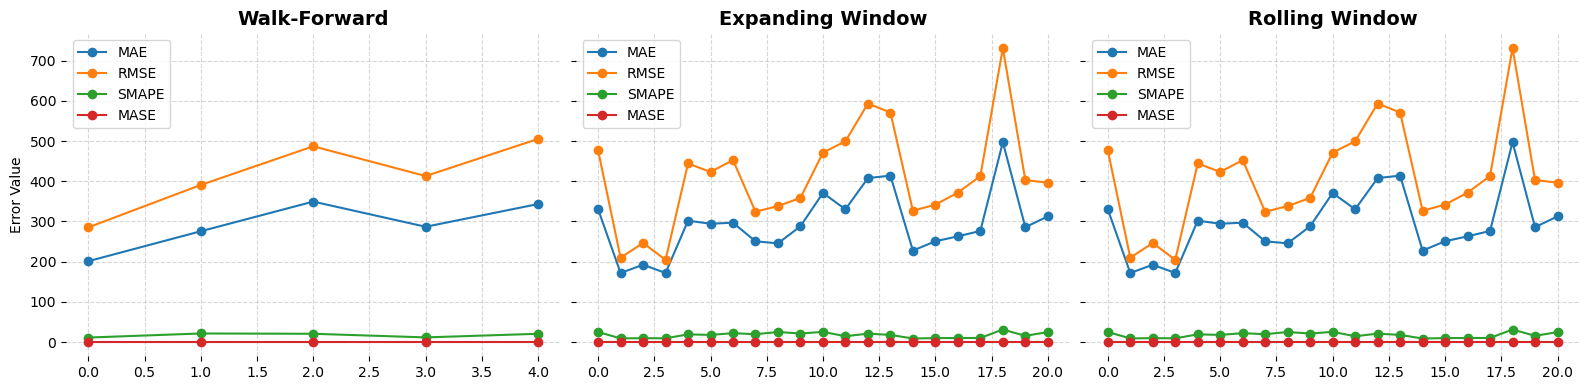

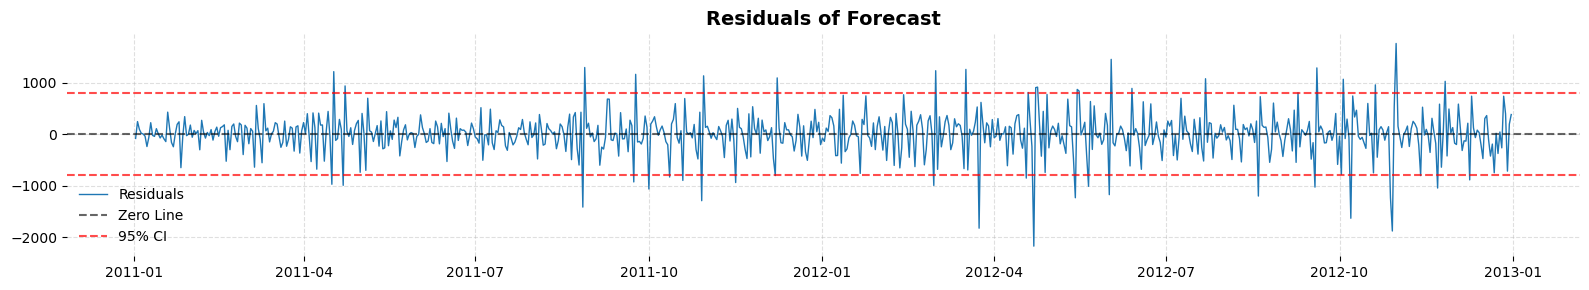

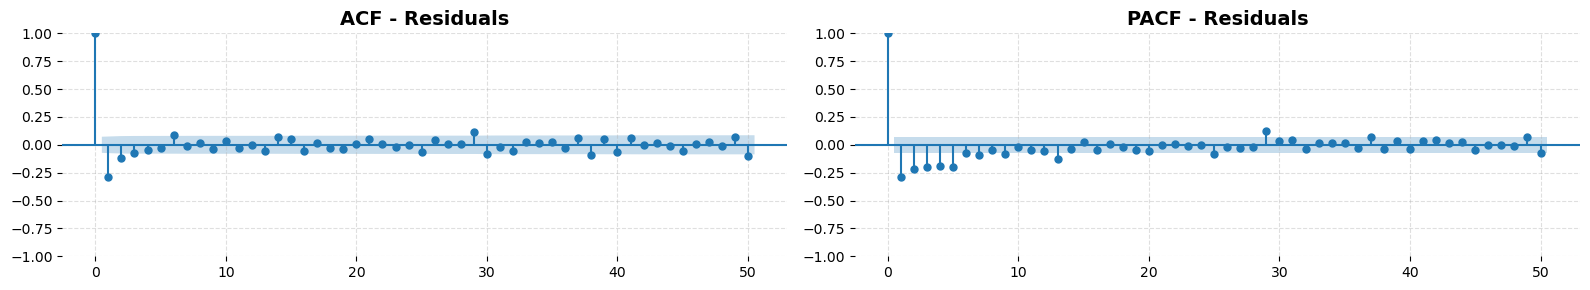

1       415.834439
2       659.495676
3       750.805907
4       766.938328
5       769.481456
          ...     
726     981.195783
727    1374.491192
728     656.034969
729     849.465702
730    1229.748625
Name: bikes_rented, Length: 730, dtype: float64

1       499.329506
2       415.834439
3       659.495676
4       750.805907
5       766.938328
          ...     
726     245.156186
727     981.195783
728    1374.491192
729     656.034969
730     849.465702
Name: naive_forecast, Length: 730, dtype: float64

1       415.834439
2       659.495676
3       750.805907
4       766.938328
5       769.481456
          ...     
726     981.195783
727    1374.491192
728     656.034969
729     849.465702
730    1229.748625
Name: bikes_rented, Length: 730, dtype: float64

1       499.329506
2       415.834439
3       659.495676
4       750.805907
5       766.938328
          ...     
726     245.156186
727     981.195783
728    1374.491192
729     656.034969
730     849.465702
Name: naive_forecast, Length: 730, dtype: float64

,Model,Baseline,Improvement
MAE,278.586325,278.586325,0.0
RMSE,407.237227,407.237227,0.0
SMAPE,18.14243,18.14243,0.0
MASE,1.0,1.0,0.0
DM Test p-value,,,nan
Statistical Significance,,,Not Significant


In [50]:
naive_forecast_metrics, naive_forecast_comparison_results = validate_forecast(df_naive=df_naive_forecast, df_forecast=df_naive_forecast, df_baseline=df_naive_forecast, to_forecast_column = forecast_column, forecasted_column = 'naive_forecast')

## BASE FORECASTING

#### RANDOM WALK

In [57]:
def random_walk_forecast(df, forecast_column, date_column="date", steps=30):
    df_forecast = df.copy()
    df_forecast[date_column] = pd.to_datetime(df_forecast[date_column])

    df_forecast["random_walk_forecast"] = df_forecast[forecast_column].shift(1)
    df_forecast["is_future_forecast"] = False

    time_deltas = df_forecast[date_column].diff().dropna()
    most_common_delta = time_deltas.mode()[0] if not time_deltas.empty else pd.Timedelta(days=1)

    last_date = df_forecast[date_column].iloc[-1]
    last_value = df_forecast[forecast_column].iloc[-1]

    future_dates = [last_date + most_common_delta * i for i in range(1, steps + 1)]
    
    std_dev = df_forecast[forecast_column].diff().std() 
    random_steps = np.random.normal(0, std_dev, size=steps) 

    future_forecast = pd.DataFrame(index=range(steps), columns=df.columns)
    future_forecast[date_column] = future_dates  
    future_forecast[forecast_column] = None  
    future_forecast["random_walk_forecast"] = last_value + np.cumsum(random_steps)
    future_forecast["is_future_forecast"] = True  

    df_final = pd.concat([df_forecast, future_forecast], ignore_index=True)

    return df_final


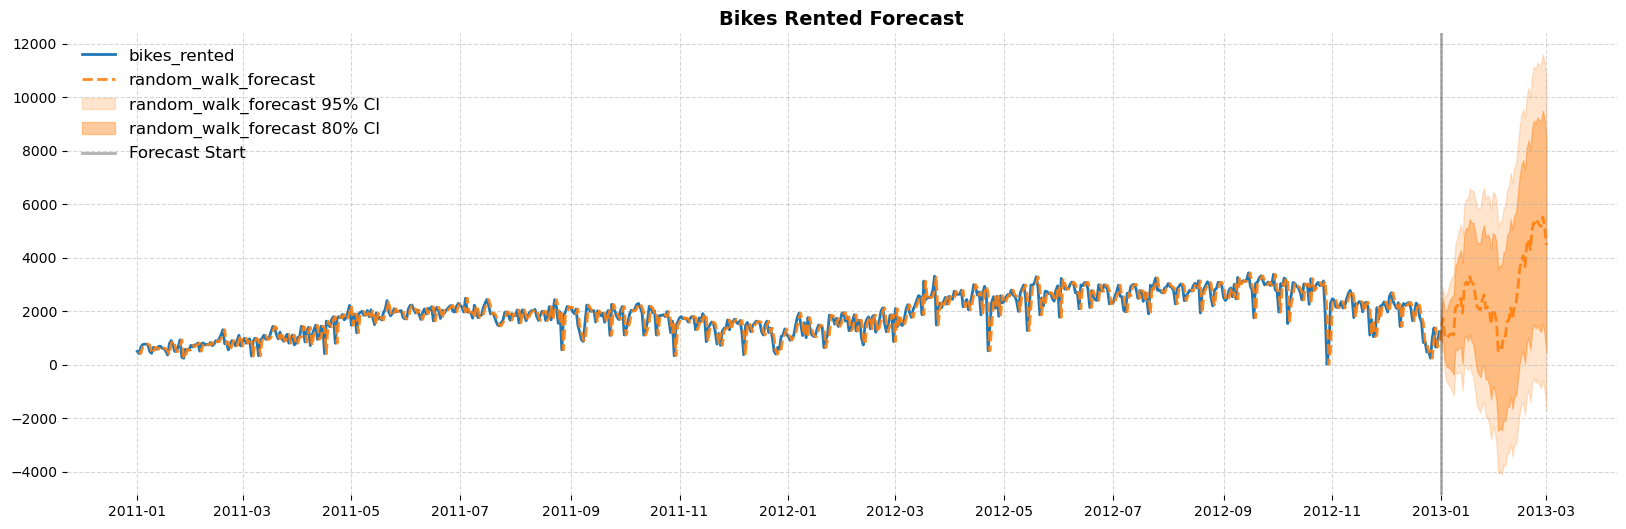

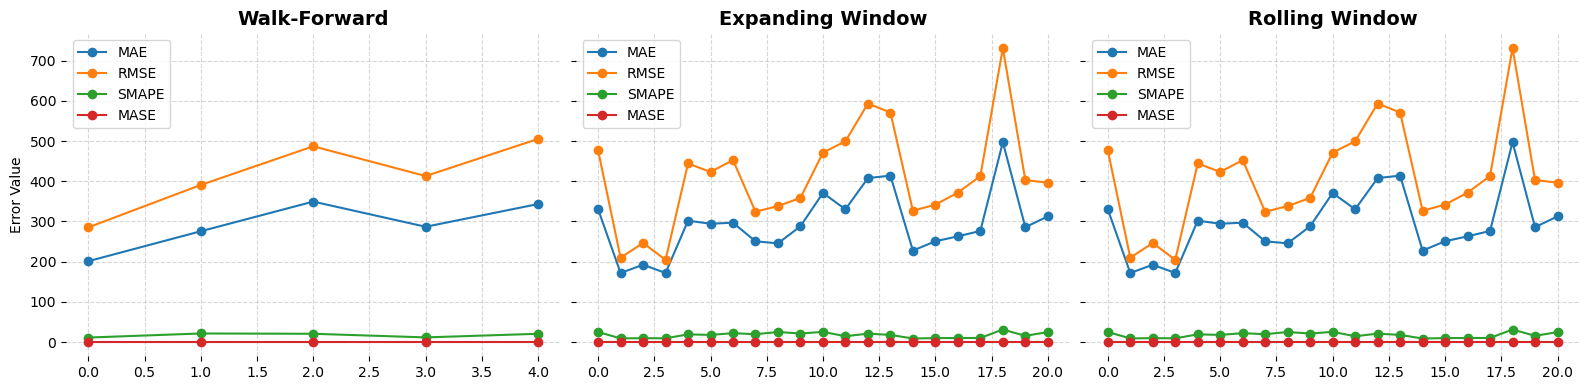

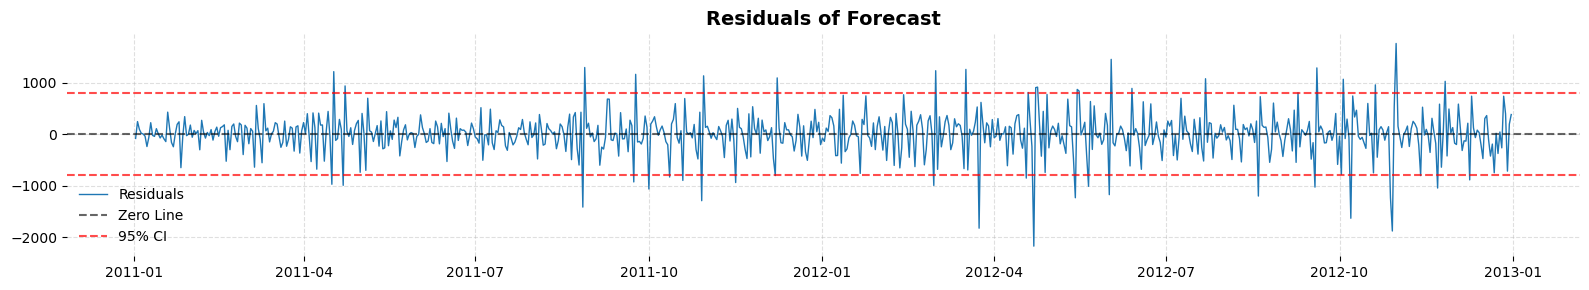

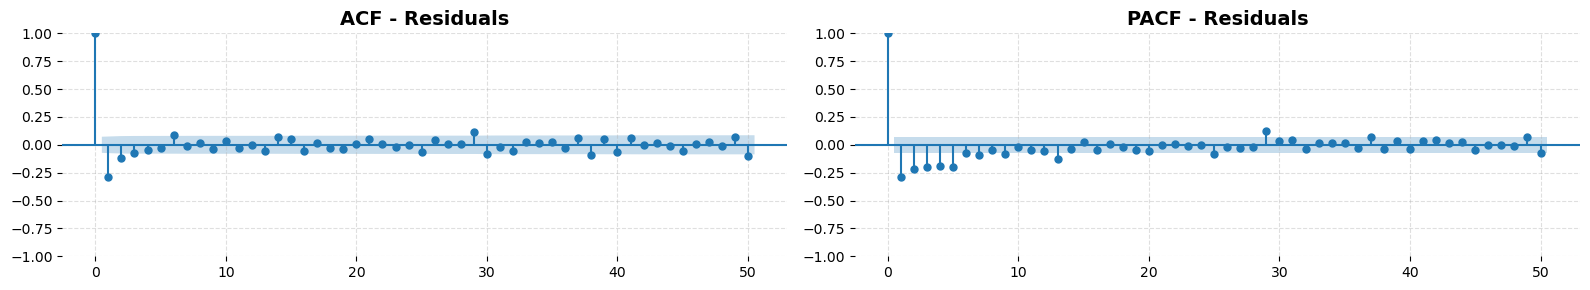

,Model,Baseline,Improvement
MAE,278.586325,278.586325,0.0
RMSE,407.237227,407.237227,0.0
SMAPE,18.14243,18.14243,0.0
MASE,1.0,1.0,0.0
DM Test p-value,,,nan
Statistical Significance,,,Not Significant


In [58]:
df_random_walk_forecast = random_walk_forecast(df_transformed, forecast_column, steps=60)
random_walk_forecast_metrics, random_walk_forecast_comparison_results = validate_forecast(df_naive=df_naive_forecast, df_forecast=df_random_walk_forecast, df_baseline=df_naive_forecast, to_forecast_column = forecast_column, forecasted_column = 'random_walk_forecast')

#### EXPONENTIAL SMOOTHING

## STATISTICAL FORECASTING

## ML FORECAST FEATURE ENGINEERING

#### COMPLETE CORRELATION AND COLLINEARITY

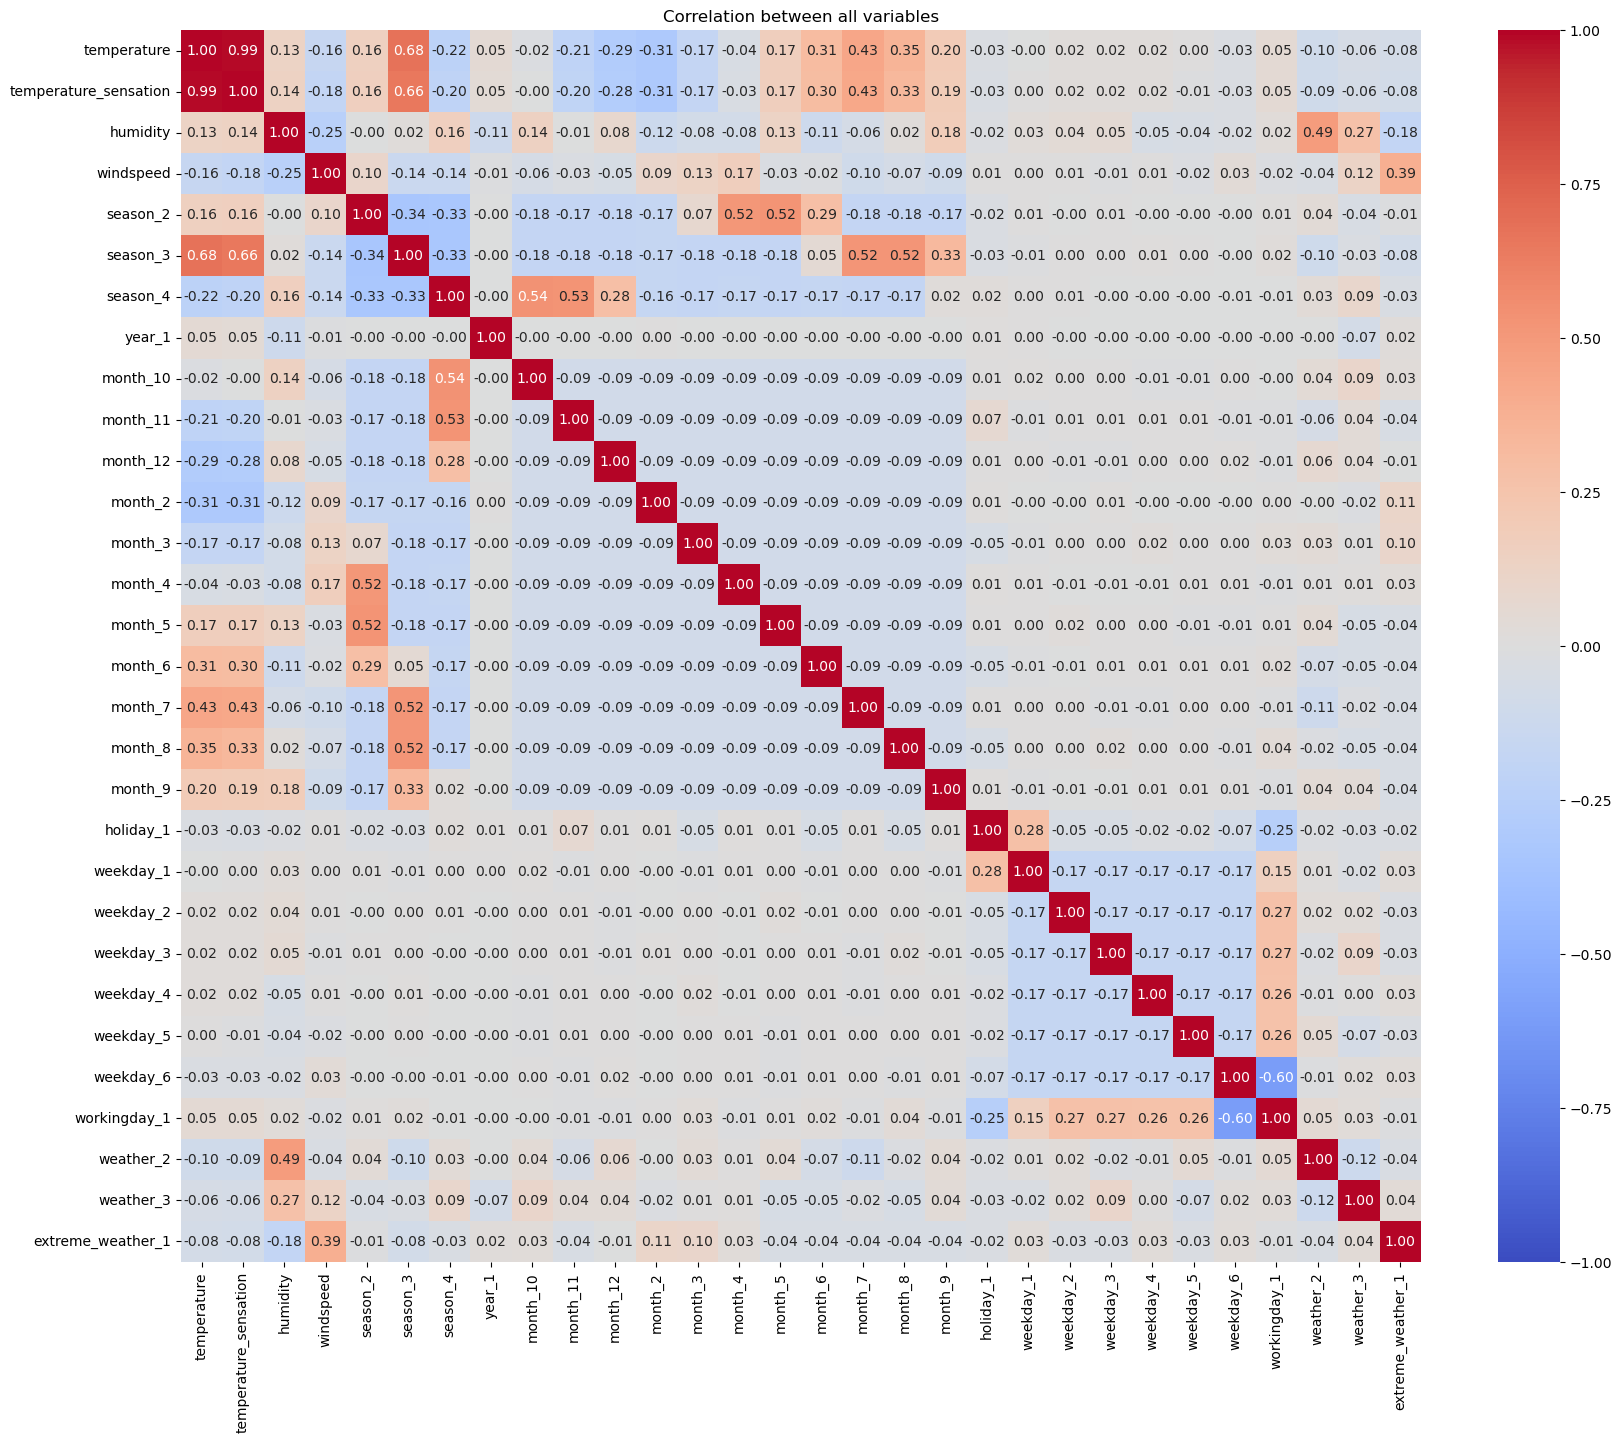

In [44]:
plt.figure(figsize=(20, 16))
df_encoded_to_corr = pd.get_dummies(df.drop(columns=[target_column, "date"], errors="ignore"), drop_first=True)
df_corr = df_encoded_to_corr.corr()
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between all variables")
plt.show()